In [1051]:
import pandas as pd
from num2words import num2words
import re
import string
from numba import njit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
from num2words import num2words
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import math
import requests
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
import nltk

Functions

In [694]:
def convert_number(text):
    def replace_numbers(match):
        num = int(match.group(0))
        return num2words(num, lang='ru')
    converted_text = re.sub(r'\d+', replace_numbers, text)

    return converted_text

In [695]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [1052]:
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words("russian")
    stopwords.append('очень')
    stopwords.append('спасибо')
    stopwords.append('понравился')
    stop_words = set(stopwords) # Use Russian stopwords
    text = text.split()
    filtered_text = [word for word in text if word not in stop_words] # Lowercasing for case-insensitivity
    return ' '.join(filtered_text)


In [697]:
stemmer = SnowballStemmer("russian")
def stem_words(text):
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems

In [698]:
def filter_cyrillic(text):
    pattern = r'[^\u0400-\u04FF ]+'
    filtered_text = re.sub(pattern, ' ', text)
    filtered_text = re.sub(r'\s+', ' ', filtered_text).strip()
    return filtered_text

In [699]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,  
        stop_words=stopwords.words('russian'), 
        use_idf=True, 
        smooth_idf=True, 
        sublinear_tf=False
    )
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(data)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names

In [700]:

def get_price_hist(id_list):
    '''
    Gets features for the products scrapped before
    '''
    z = pd.DataFrame()
    for id in tqdm(id_list):
        x = pd.DataFrame()
        date_row = []
        price_row = []
        try:
                try:
                    shard =  math.floor(id/14000000)
                    str_id  = str(id)
                    vol = str_id[:-5]
                    part = str_id[:-3]
                    if shard <10:
                        link = f'https://basket-0{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/price-history.json'
                    else:
                        link = f'https://basket-{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/price-history.json'
                    r = requests.get(link)
                    r = r.json()
                    for i in r:
                        date = datetime.fromtimestamp(i['dt'])
                        date = date.strftime('%d.%m.%Y')
                        date_row.append(date)
                        price_row.append(float((i['price']['RUB']) / 100))
                except:
                    id = id
                try:
                    shard =  math.ceil(id/14000000)
                    str_id  = str(id)
                    vol = str_id[:-5]
                    part = str_id[:-3]
                    if shard <10:
                        link = f'https://basket-0{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/price-history.json'
                    else:
                        link = f'https://basket-{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/price-history.json'
                    r = requests.get(link)
                    r = r.json()    
                    for i in r:
                        date = datetime.fromtimestamp(i['dt'])
                        date = date.strftime('%d.%m.%Y')
                        date_row.append(date)
                        price_row.append(float((i['price']['RUB']) / 100))
                except:
                     id = id
                try:
                    shard =  round(id/14000000)
                    str_id  = str(id)
                    vol = str_id[:-5]
                    part = str_id[:-3]
                    if shard <10:
                        link = f'https://basket-0{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/price-history.json'
                    else:
                        link = f'https://basket-{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/price-history.json'
                    r = r.json()
                    r = requests.get(link)           
                    for i in r:
                        date = datetime.fromtimestamp(i['dt'])
                        date = date.strftime('%d.%m.%Y')
                        date_row.append(date)
                        price_row.append(float((i['price']['RUB']) / 100))
                except:
                         id = id
                try:
                    shard =  round(id/14000000) - 1
                    str_id  = str(id)
                    vol = str_id[:-5]
                    part = str_id[:-3]
                    if shard <10:
                        link = f'https://basket-0{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/price-history.json'
                    else:
                        link = f'https://basket-{shard}.wb.ru/vol{vol}/part{part}/{str_id}/info/price-history.json'
                    r = requests.get(link)
                    r = r.json()
                    for i in r:
                        date = datetime.fromtimestamp(i['dt'])
                        date = date.strftime('%d.%m.%Y')
                        date_row.append(date)
                        price_row.append(float((i['price']['RUB']) / 100))
                except: 
                        id = id
        except:
            z = z
        x['date']= date_row
        x['price']= price_row
        x['SKU']= str_id
        z = pd.concat([z,x])
    return z

In [701]:
from tqdm import tqdm
def get_rev(id_list):
    z = pd.DataFrame()
    for id in tqdm(id_list):
        x = pd.DataFrame()
        num_rev = []
        num_prom = []
        SKU = []
        id = str(id)
        link = f'https://card.wb.ru/cards/v2/detail?appType=1&curr=rub&dest=-1257786&spp=30&nm={id}'
        r = requests.get(link)
        r = r.json()
        try:
            num_rev.append(r['data']['products'][0]['feedbacks'])
            num_prom.append(len(r['data']['products'][0]['promotions']))
            SKU.append(id)
            x['num_rev'] = num_rev
            x['num_prom'] = num_prom
            x['SKU'] = SKU
            z = pd.concat([z,x])
        except: z = z
    return z


<h3>EDA</h3>

In [702]:
product_top = pd.read_csv('full_data_top.csv')
product_mid = pd.read_csv('full_data_mid.csv')
product_bot = pd.read_csv('full_data_bot.csv')

In [703]:
product = pd.concat([product_top[:500],product_mid[:500],product_bot[:500]])

In [706]:
product = product.drop(columns=[ 'Unnamed: 0', 'Gender'])

columns_to_convert = ['Revenue average', 'Average price', 'Sales Per Day Average']

for col in columns_to_convert:
    product[col] = product[col].replace('[\$,]', '', regex=True).astype(float)

product['Color'] = product['Color'].fillna('Unknown')

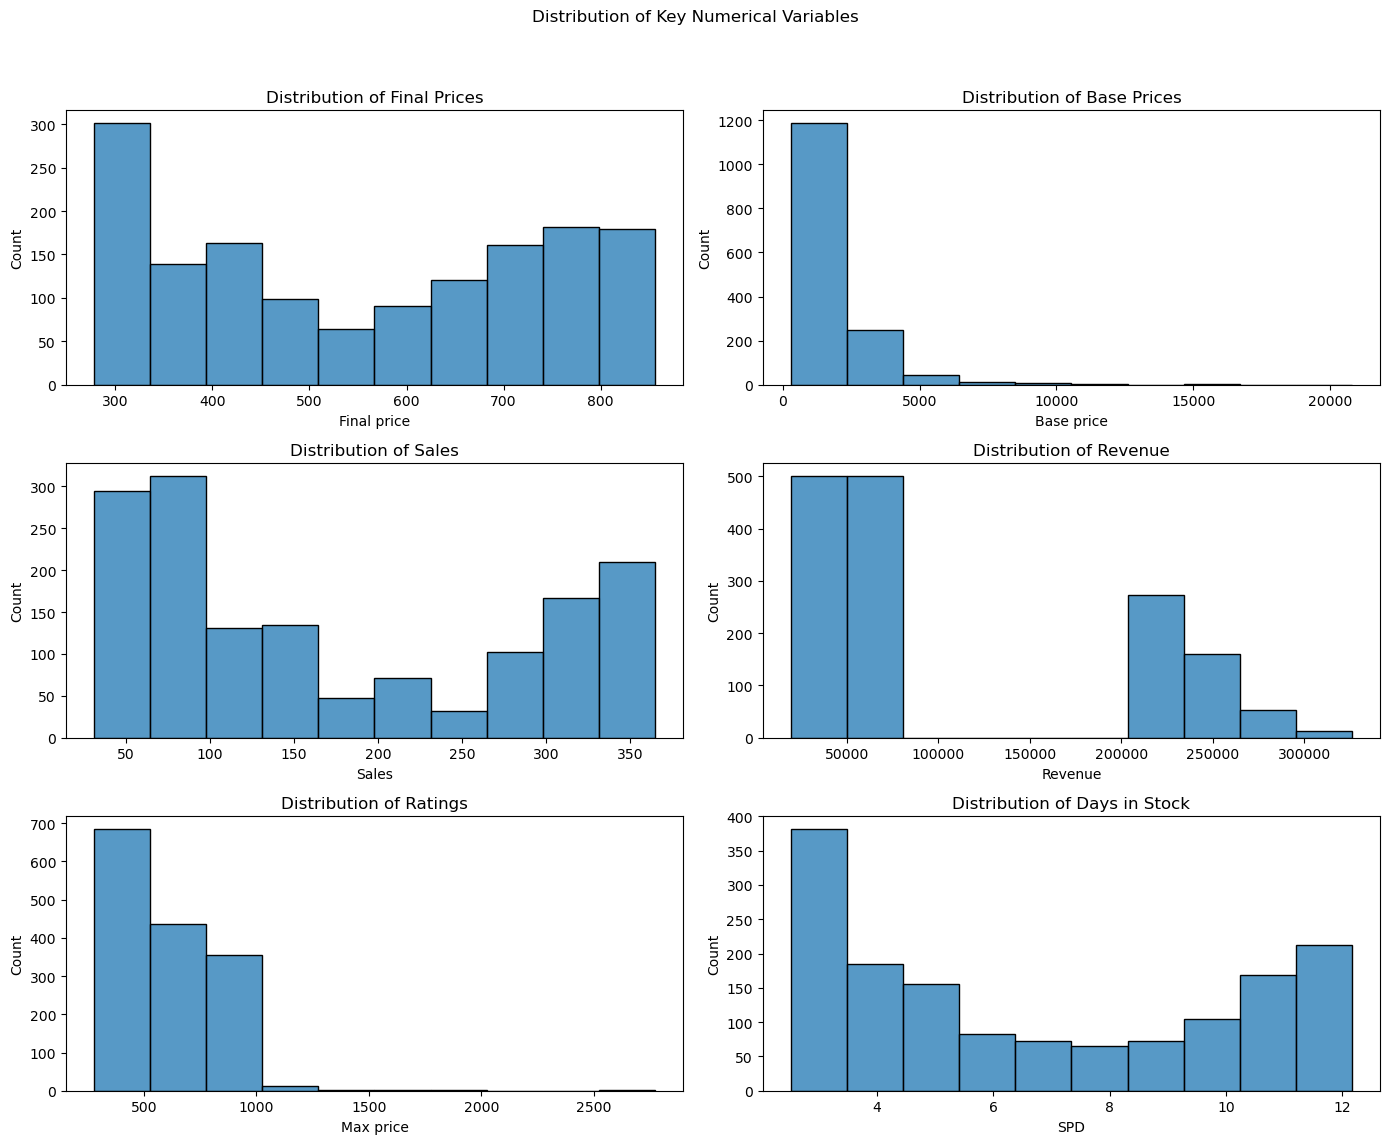

SKU        Revenue  Revenue average  Category Position  \
count  1.500000e+03    1500.000000     1.500000e+03         1500.00000   
mean   1.158506e+08  107381.800000     2.269699e+07         1153.07600   
std    6.155117e+07   94265.630391     3.032867e+07         1427.95919   
min    2.472313e+06   19490.000000     6.660000e+02           -1.00000   
25%    5.928718e+07   21739.250000     2.159775e+04           45.00000   
50%    1.395814e+08   64115.500000     7.124167e+06          493.50000   
75%    1.672991e+08  218917.750000     2.155733e+07         1806.50000   
max    2.112618e+08  326033.000000     1.086777e+08         4997.00000   

           Balance      Comments       Rating  Card Rating  Final price  \
count  1500.000000   1500.000000  1500.000000  1500.000000  1500.000000   
mean    224.878667   4421.250667     4.990000    73.632667   551.891333   
std     347.756102   5584.130629     0.099532    10.445915   192.352369   
min       0.000000   1003.000000     4.000000     0.000000   278.000000   
25%      17.000000   1570.750000     5.000000    70.000000   367.750000   
50%     104.000000   2582.000000     5.000000    73.000000   551.500000   
75%     289.000000   4986.500000     5.000000    80.000000   735.000000   
max    3937.000000  64668.000000     5.000000   100.000000   856.000000   

         Min price    Max price  Average price    Base price    SPP Price  \
count  1500.000000  1500.000000   1.500000e+03   1500.000000  1500.000000   
mean    511.110667   589.800667   4.362510e+06   1776.640000   551.891333   
std     179.782260   235.674830   2.884239e+06   1474.284629   192.352369   
min     183.000000   278.000000   2.630000e+02    298.000000   278.000000   
25%     343.000000   385.750000   2.631614e+06    890.000000   367.750000   
50%     501.500000   585.000000   4.460527e+06   1423.000000   551.500000   
75%     675.250000   777.250000   6.989140e+06   2160.500000   735.000000   
max     856.000000  2772.000000   9.294982e+06  20800.000000   856.000000   

       Days in stock        Sales  Sales Per Day Average   Pics Count  \
count    1500.000000  1500.000000            1500.000000  1500.000000   
mean       24.734667   173.245333           38469.513333     8.234667   
std         7.440240   113.632995           40756.670515     4.448459   
min         4.000000    31.000000               2.000000     0.000000   
25%        19.000000    72.000000             102.000000     5.000000   
50%        30.000000   135.500000           24667.000000     7.000000   
75%        30.000000   299.000000           67667.000000    11.000000   
max        30.000000   365.000000          121667.000000    30.000000   

               SPD  
count  1500.000000  
mean      6.711957  
std       3.376393  
min       2.517241  
25%       3.466667  
50%       5.723810  
75%      10.289286  
max      12.166667

In [708]:
numerical_descriptive_stats = product.describe()


fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Distribution of Key Numerical Variables')


sns.histplot(product['Final price'],bins=10, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Final Prices')

sns.histplot(product['Base price'], bins=10, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Base Prices')

sns.histplot(product['Sales'], bins=10, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Sales')

sns.histplot(product['Revenue'], bins=10, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Revenue')

sns.histplot(product['Max price'], bins=10, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Ratings')

sns.histplot(product['SPD'], bins=10, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Days in Stock')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

numerical_descriptive_stats

In [709]:
numeric_cols = ['Revenue', 'Revenue average','Final price', 'Min price',
       'Max price', 'Average price', 'Base price','Sales', 'Sales Per Day Average','SPD']
product_log = pd.DataFrame()
for col in numeric_cols:
    product_log[col + '_log'] = np.log(product[col])


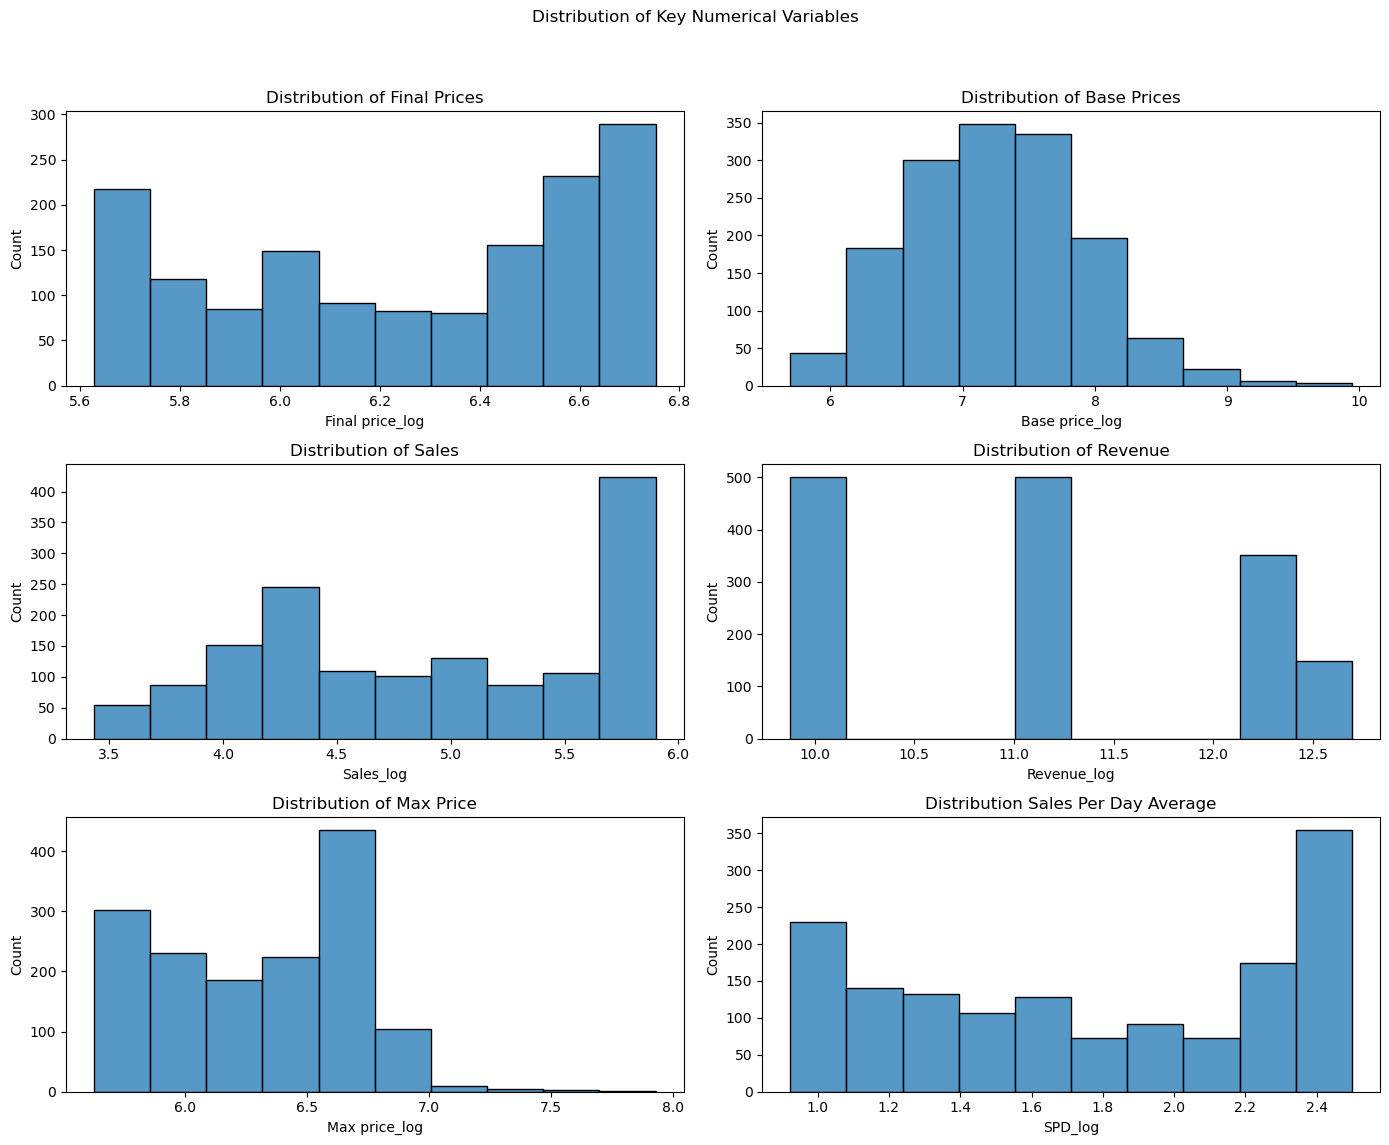

Revenue_log  Revenue average_log  Final price_log  Min price_log  \
count  1500.000000          1500.000000      1500.000000    1500.000000   
mean     11.130573            14.225736         6.246667       6.169382   
std       0.991007             3.703437         0.374212       0.375341   
min       9.877657             6.501290         5.627621       5.209486   
25%       9.986875             9.980344         5.907403       5.837730   
50%      11.068441            15.779003         6.312638       6.217603   
75%      12.296451            16.886227         6.599870       6.515083   
max      12.694754            18.503897         6.752270       6.752270   

       Max price_log  Average price_log  Base price_log    Sales_log  \
count    1500.000000        1500.000000     1500.000000  1500.000000   
mean        6.300502          13.794035        7.257405     4.902833   
std         0.403204           3.428485        0.650110     0.740543   
min         5.627621           5.572154        5.697093     3.433987   
25%         5.955189          14.783102        6.791221     4.276666   
50%         6.371612          15.310777        7.260522     4.908965   
75%         6.655762          15.759868        7.678095     5.700444   
max         7.927324          16.044985        9.942708     5.899897   

       Sales Per Day Average_log      SPD_log  
count                1500.000000  1500.000000  
mean                    8.383295     1.763926  
std                     3.434363     0.542730  
min                     0.693147     0.923164  
25%                     4.624973     1.243194  
50%                    10.113222     1.744633  
75%                    11.122354     2.331103  
max                    11.709043     2.498700

In [711]:
numerical_descriptive_stats = product_log.describe()


fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Distribution of Key Numerical Variables')


sns.histplot(product_log['Final price_log'],bins=10, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Final Prices')

sns.histplot(product_log['Base price_log'], bins=10, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Base Prices')

sns.histplot(product_log['Sales_log'], bins=10, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Sales')

sns.histplot(product_log['Revenue_log'], bins=10, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Revenue')

sns.histplot(product_log['Max price_log'], bins=10, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Max Price')

sns.histplot(product_log['SPD_log'], bins=10, ax=axes[2, 1])
axes[2, 1].set_title('Distribution Sales Per Day Average')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

numerical_descriptive_stats

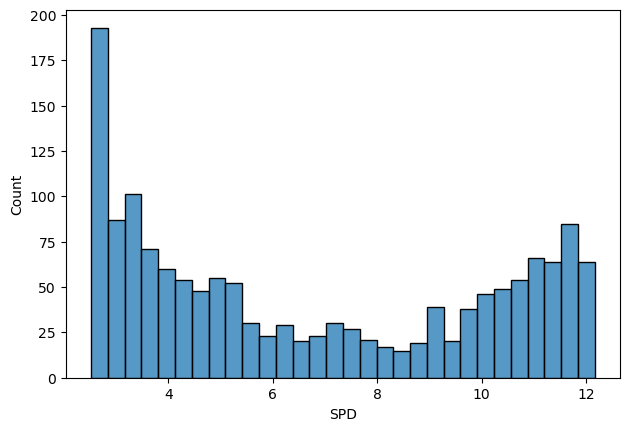

In [713]:
sns.histplot(product['SPD'], bins=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [1082]:
best_selling_list = list(product['SKU'].iloc[:500])
average_selling_list  = list(product['SKU'].iloc[500:1000])
worst_selling_list = list(product['SKU'].iloc[1000:])
best_selling = product.loc[product['SKU'].isin(best_selling_list)]
average_selling = product.loc[product['SKU'].isin(average_selling_list)]
worst_selling = product.loc[product['SKU'].isin(worst_selling_list)]

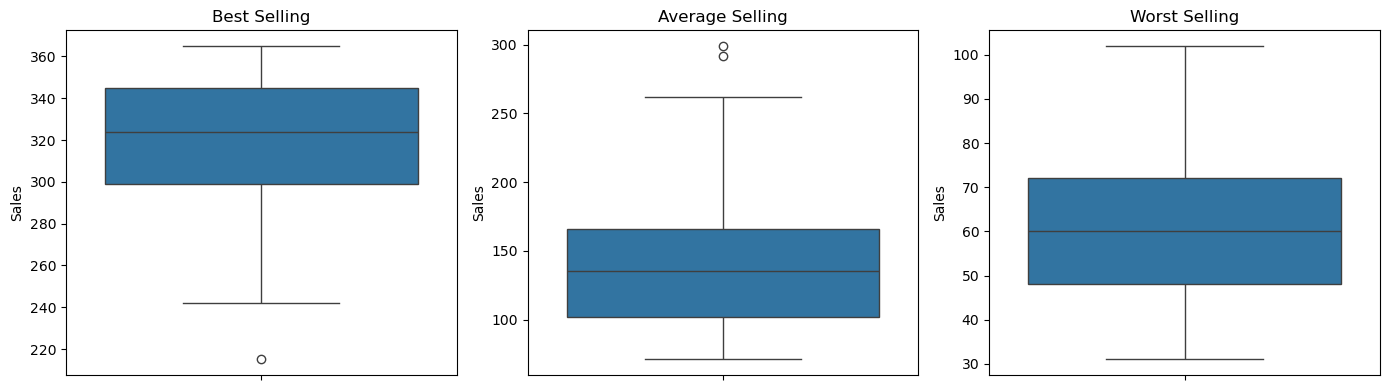

In [1083]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  


sns.boxplot(data=best_selling['Sales'], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['Sales'], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['Sales'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

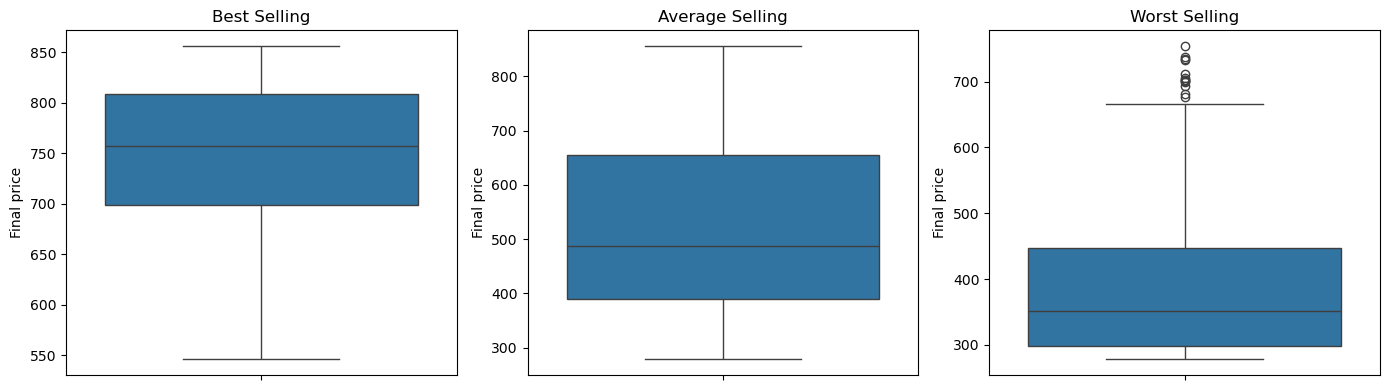

In [1084]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4)) 

sns.boxplot(data=best_selling['Final price'], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['Final price'], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['Final price'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

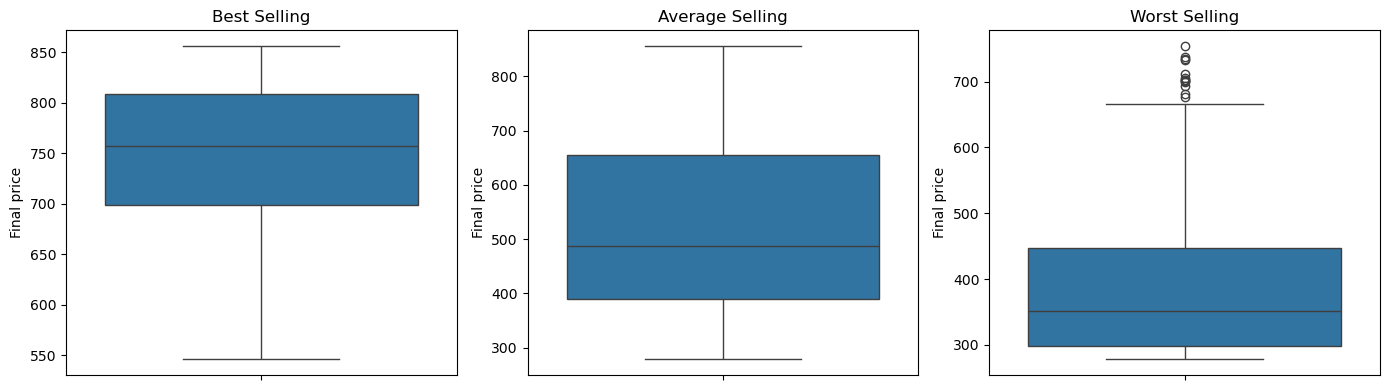

In [717]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

threshold_best_sales= 6000
threshold_avg_sales= 1500
threshold_worst_sales = 0

sns.boxplot(data=best_selling['Final price'][best_selling['Final price']<= threshold_best_sales], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['Final price'][average_selling['Final price']<= threshold_avg_sales], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['Final price'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

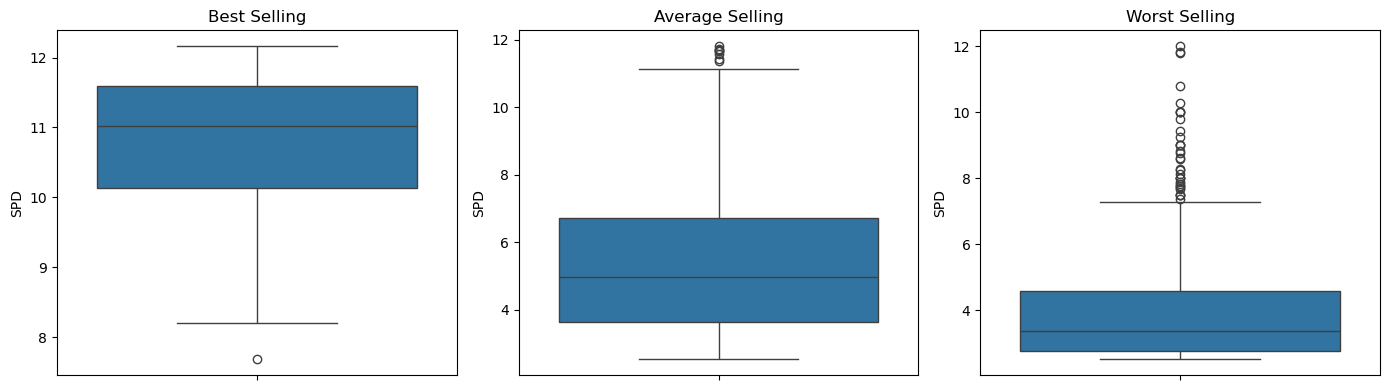

In [1088]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4)) 

sns.boxplot(data=best_selling['SPD'], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['SPD'], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['SPD'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

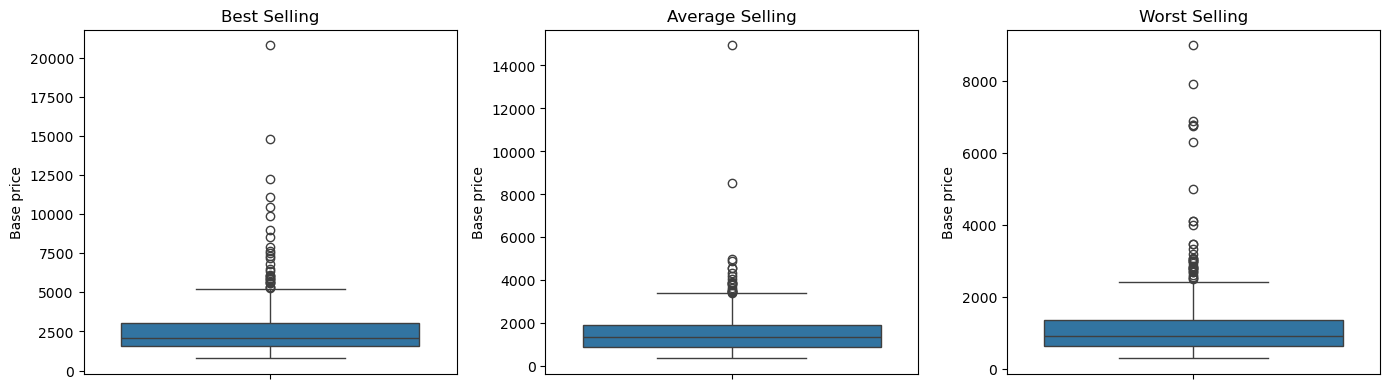

In [1085]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4)) 

sns.boxplot(data=best_selling['Base price'], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['Base price'], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['Base price'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

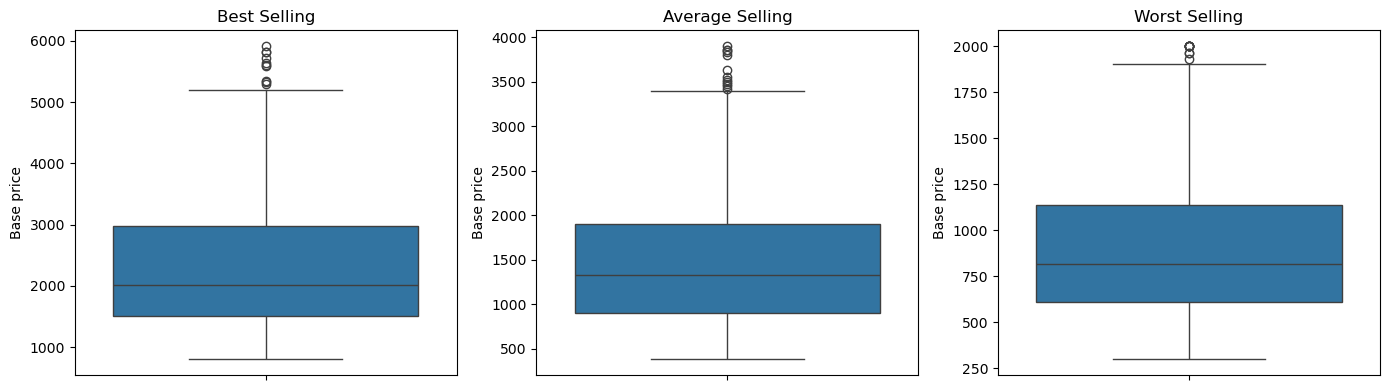

In [1087]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

threshold_best_sales= 6000
threshold_avg_sales= 4000
threshold_worst_sales = 2000

sns.boxplot(data=best_selling['Base price'][best_selling['Base price']<= threshold_best_sales], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['Base price'][average_selling['Base price']<= threshold_avg_sales], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['Base price'][worst_selling['Base price']<= threshold_worst_sales], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

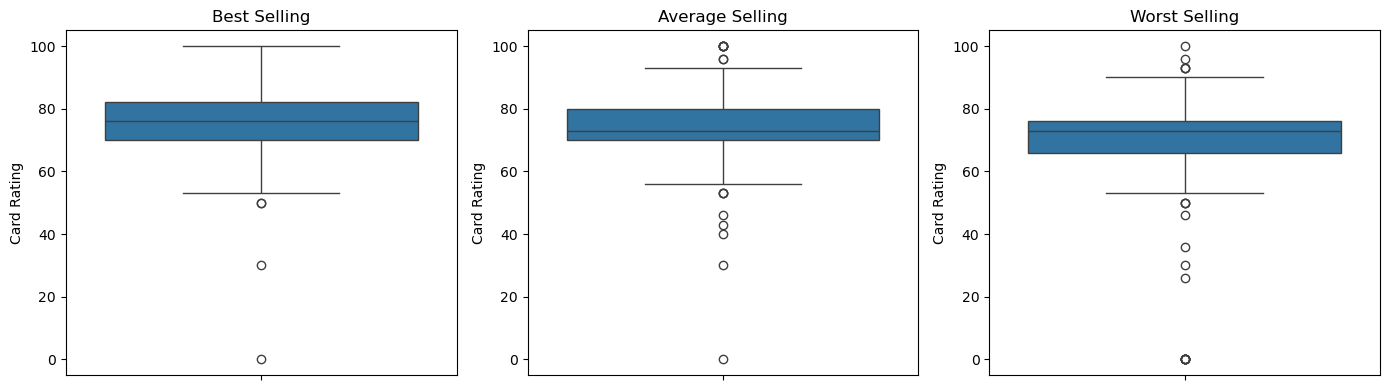

In [721]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

sns.boxplot(data=best_selling['Card Rating'], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['Card Rating'], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['Card Rating'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

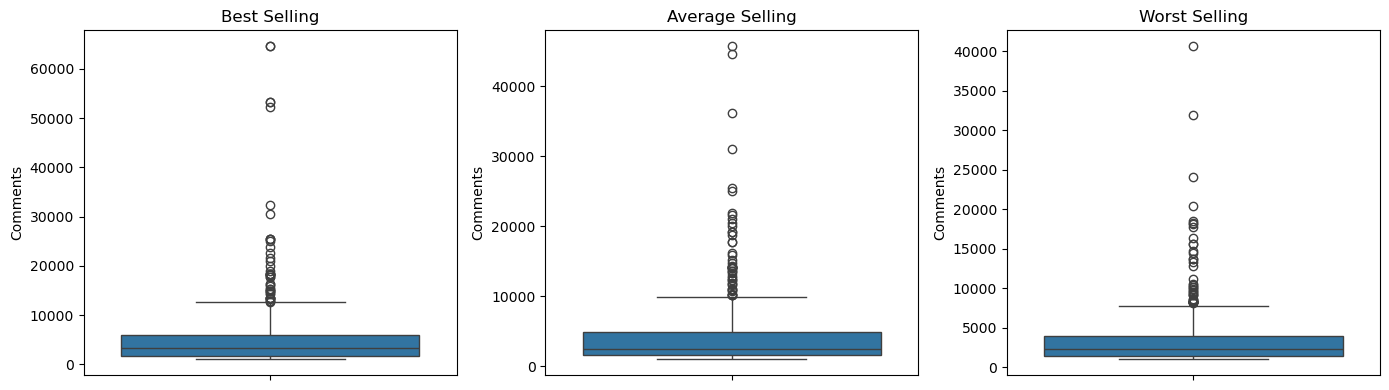

In [722]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

sns.boxplot(data=best_selling['Comments'], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['Comments'], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['Comments'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

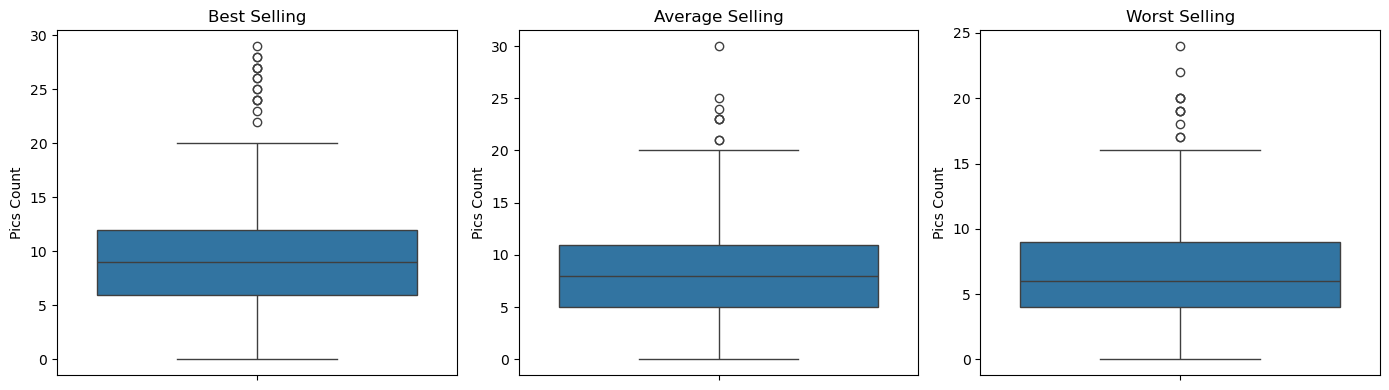

In [1089]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

sns.boxplot(data=best_selling['Pics Count'], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['Pics Count'], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['Pics Count'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

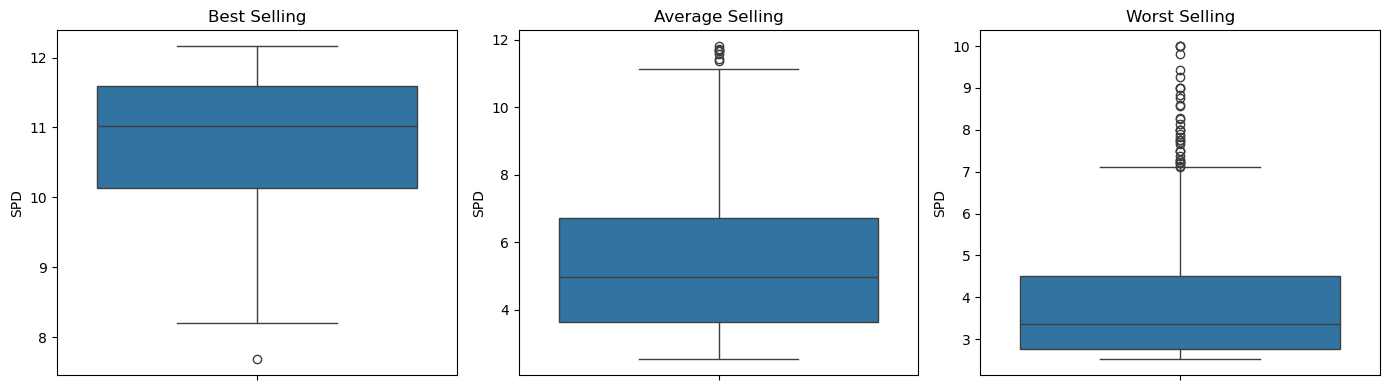

In [723]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

threshold_best_sales= 2000
threshold_avg_sales= 25
threshold_worst_sales = 10

sns.boxplot(data=best_selling['SPD'][best_selling['SPD']<= threshold_best_sales], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['SPD'][average_selling['SPD']<= threshold_avg_sales], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['SPD'][worst_selling['SPD']<= threshold_worst_sales], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

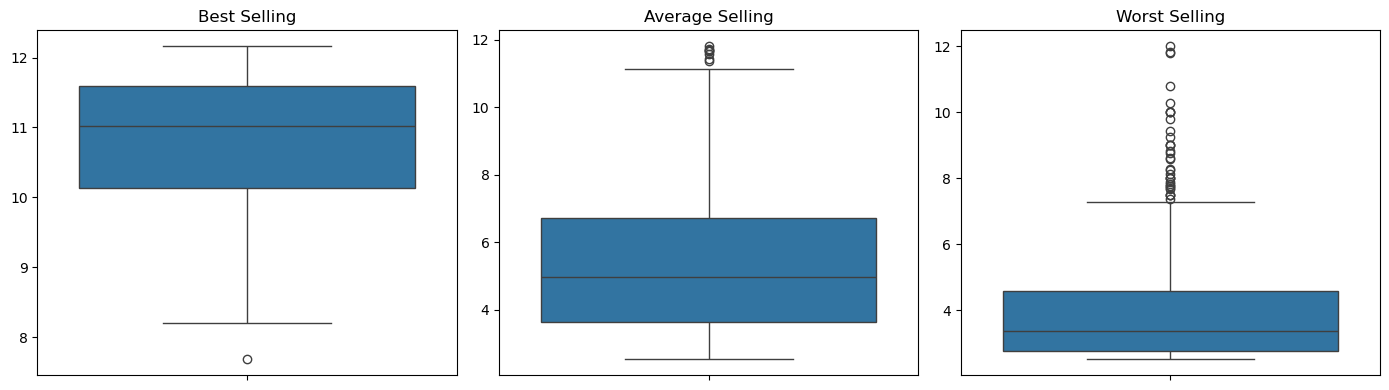

In [726]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

sns.boxplot(data=best_selling['Sales']/best_selling['Days in stock'], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['Sales']/average_selling['Days in stock'], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['Sales']/worst_selling['Days in stock'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

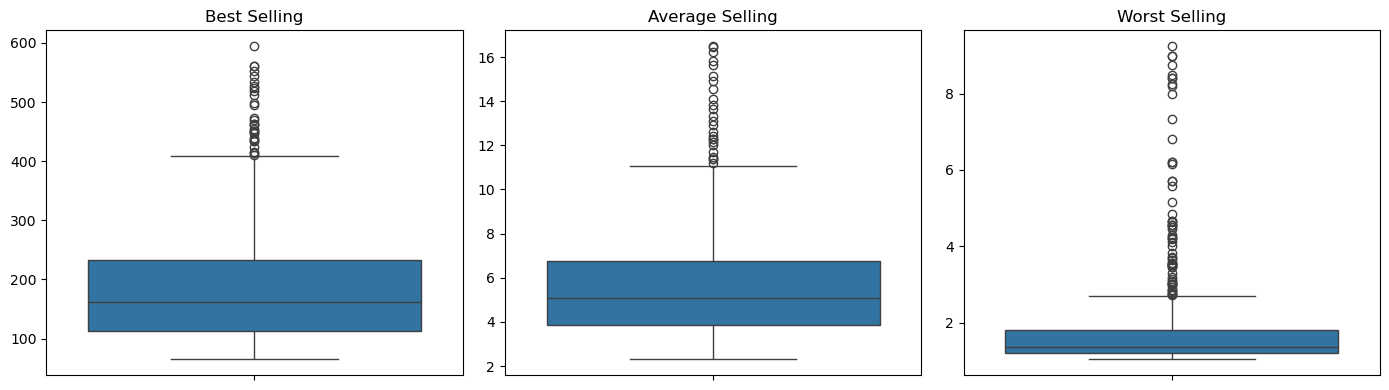

In [383]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

threshold_best_sales= 600
threshold_avg_sales= 20
threshold_worst_sales = 10

sns.boxplot(data=(best_selling['Sales']/best_selling['Days in stock'])[(best_selling['Sales']/best_selling['Days in stock']) <= threshold_best_sales], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=(average_selling['Sales']/average_selling['Days in stock'])[(average_selling['Sales']/average_selling['Days in stock']) <= threshold_avg_sales], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=(worst_selling['Sales']/worst_selling['Days in stock'])[(worst_selling['Sales']/worst_selling['Days in stock']) <= threshold_worst_sales], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

<h3>EDA Textual</h3>

In [1028]:
reviews_top = pd.read_csv('new_df_rev_top.csv')
reviews_mid = pd.read_csv('new_df_rev_mid.csv')
reviews_bot = pd.read_csv('new_df_rev_bot.csv')
reviews = pd.concat([reviews_top,reviews_mid,reviews_bot])
maping_top = pd.read_csv('wb_top.csv')[['id','mid']]
maping_mid = pd.read_csv('wb_mid.csv')[['id','mid']]
maping_bot = pd.read_csv('wb_bot.csv')[['id','mid']]
maping = pd.concat([maping_top,maping_mid,maping_bot])

In [1037]:
pm = product.merge(maping,left_on='SKU',right_on='id',how='left').drop_duplicates()
reviews = reviews[reviews['id'].isin(pm['mid'])]
product_with_rev = pm.merge(reviews,left_on='mid',right_on='id',how='left').drop_duplicates()
product_with_rev = product_with_rev.groupby('SKU').head(500)

In [1053]:
product_with_rev['text'] = product_with_rev['text'].apply(lambda x: str(x))
product_with_rev['text'] = product_with_rev['text'].apply(lambda x: x.lower())
product_with_rev['text'] = product_with_rev['text'].apply(convert_number)
product_with_rev['text'] = product_with_rev['text'].apply(remove_punctuation)
product_with_rev['text'] = product_with_rev['text'].apply(filter_cyrillic)
product_with_rev['text'] = product_with_rev['text'].apply(remove_stopwords)
product_with_rev['text'] = product_with_rev['text'].apply(stem_words)
product_with_rev['text'] = product_with_rev['text'].apply(lambda x: str(x))
product_with_rev['text'] = product_with_rev['text'].apply(remove_punctuation)
product_with_rev = product_with_rev.drop_duplicates()

In [1057]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
tokenizer = RegexTokenizer()

model = FastTextSocialNetworkModel(tokenizer=tokenizer)
results = model.predict(product_with_rev['text'], k=4)
res_df = pd.DataFrame(results)


In [1092]:
product_with_rev = product_with_rev.reset_index()
res_df = res_df.fillna(0)
product_with_rev['positive'] = res_df['positive']
product_with_rev['neutral']= res_df['neutral']
product_with_rev['negative'] = res_df['negative']
product_with_rev['rev_len'] = product_with_rev['text'].apply(lambda x: len(x))

In [1093]:
product_with_rev.to_csv('full_df_merged')

In [1094]:
best_selling = product_with_rev.loc[product_with_rev['SKU'].isin(best_selling_list)]
average_selling = product_with_rev.loc[product_with_rev['SKU'].isin(average_selling_list)]
worst_selling = product_with_rev.loc[product_with_rev['SKU'].isin(worst_selling_list)]

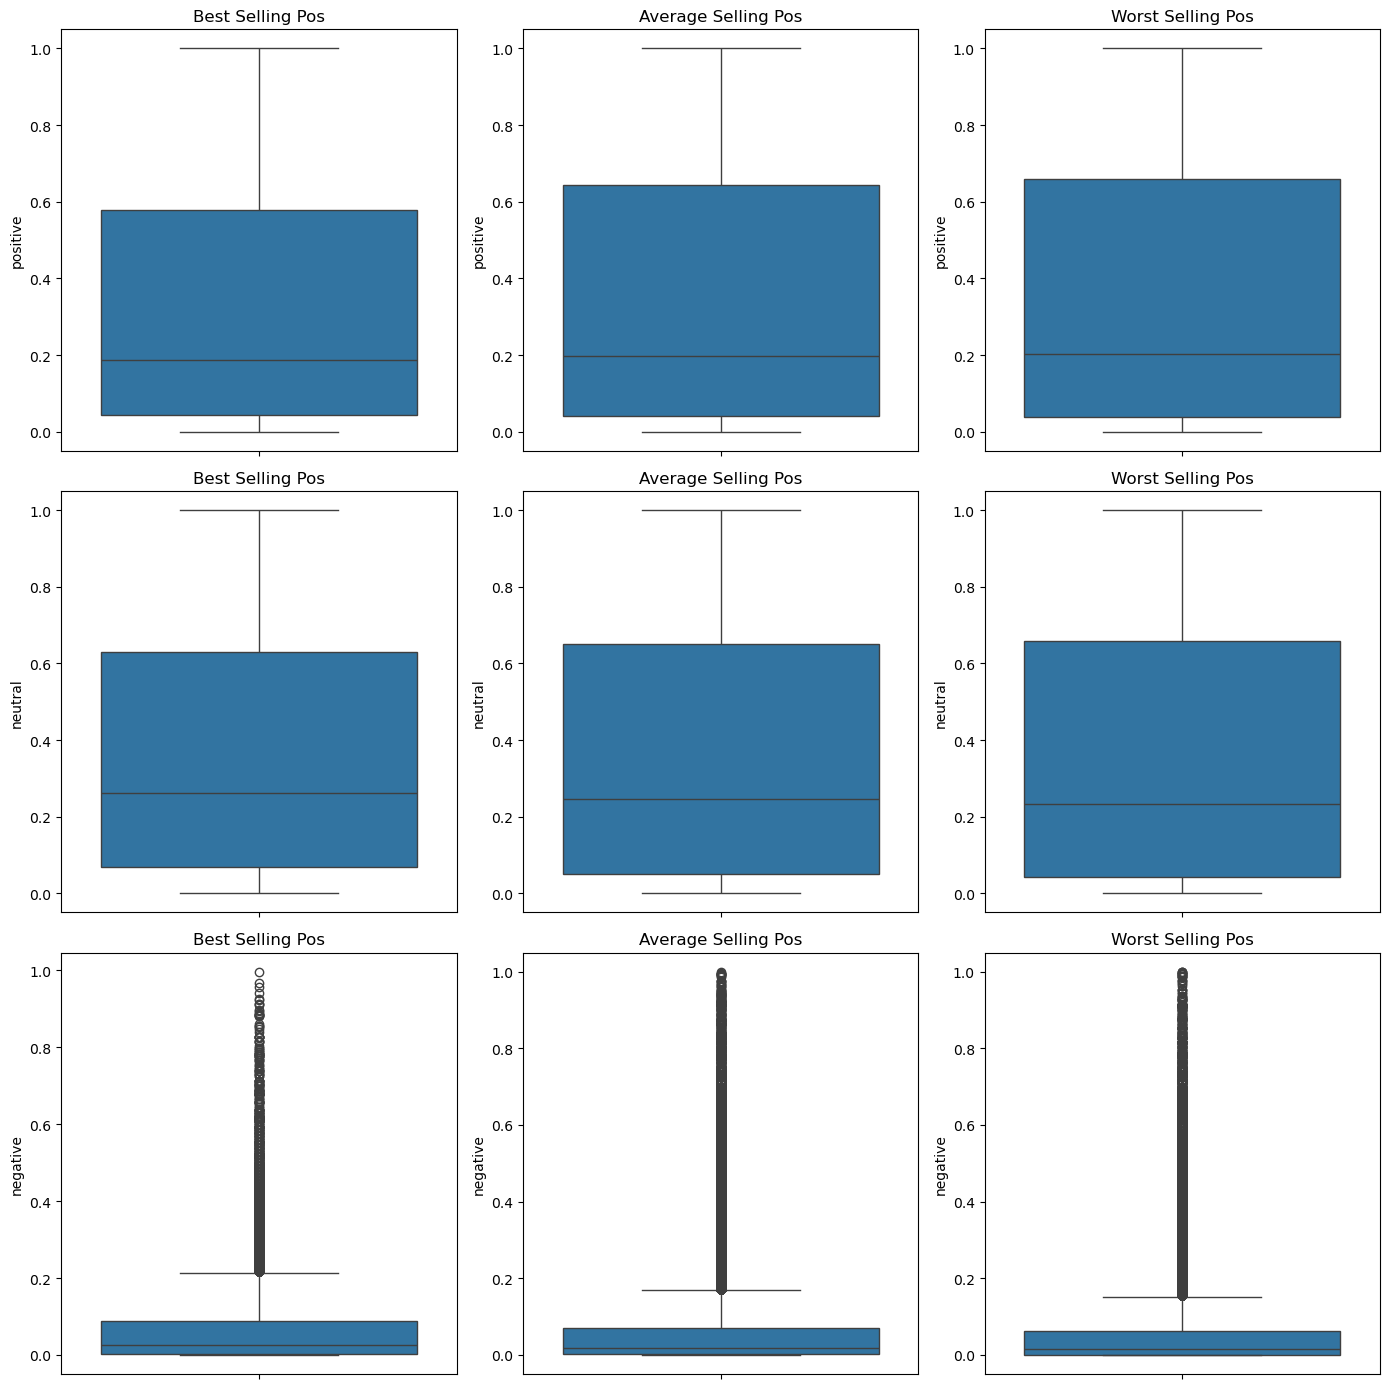

In [1095]:
fig, axes = plt.subplots(3, 3, figsize=(14, 14))  

sns.boxplot(data=best_selling['positive'], ax=axes[0,0])
axes[0,0].set_title('Best Selling Pos')

sns.boxplot(data=average_selling['positive'], ax=axes[0,1])
axes[0,1].set_title('Average Selling Pos')

sns.boxplot(data=worst_selling['positive'], ax=axes[0,2])
axes[0,2].set_title('Worst Selling Pos')

sns.boxplot(data=best_selling['neutral'], ax=axes[1,0])
axes[1,0].set_title('Best Selling Pos')

sns.boxplot(data=average_selling['neutral'], ax=axes[1,1])
axes[1,1].set_title('Average Selling Pos')

sns.boxplot(data=worst_selling['neutral'], ax=axes[1,2])
axes[1,2].set_title('Worst Selling Pos')

sns.boxplot(data=best_selling['negative'], ax=axes[2,0])
axes[2,0].set_title('Best Selling Pos')

sns.boxplot(data=average_selling['negative'], ax=axes[2,1])
axes[2,1].set_title('Average Selling Pos')

sns.boxplot(data=worst_selling['negative'], ax=axes[2,2])
axes[2,2].set_title('Worst Selling Pos')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='rev_len', ylabel='mark'>

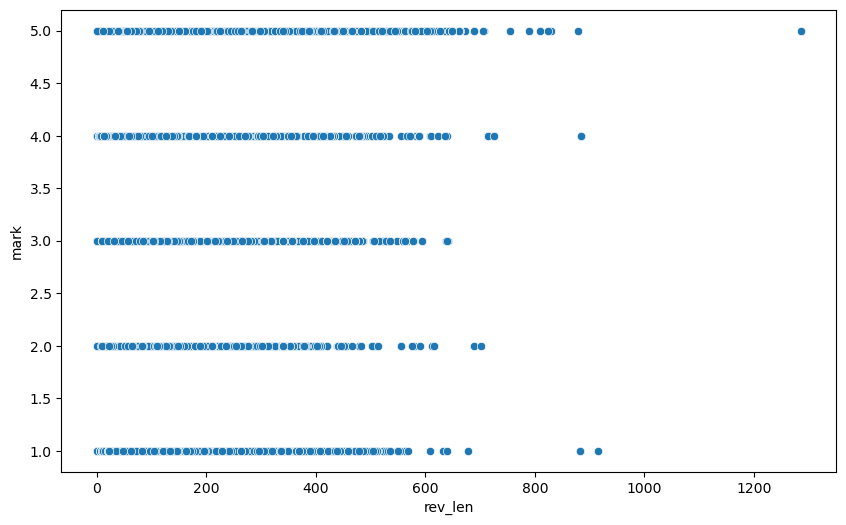

In [757]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_rev['mark'], x=product_with_rev['rev_len'])

In [758]:
best_selling = product_with_rev.loc[product_with_rev['SKU'].isin(best_selling_list)]
average_selling = product_with_rev.loc[product_with_rev['SKU'].isin(average_selling_list)]
worst_selling = product_with_rev.loc[product_with_rev['SKU'].isin(worst_selling_list)]

<AxesSubplot:xlabel='rev_len', ylabel='SPD'>

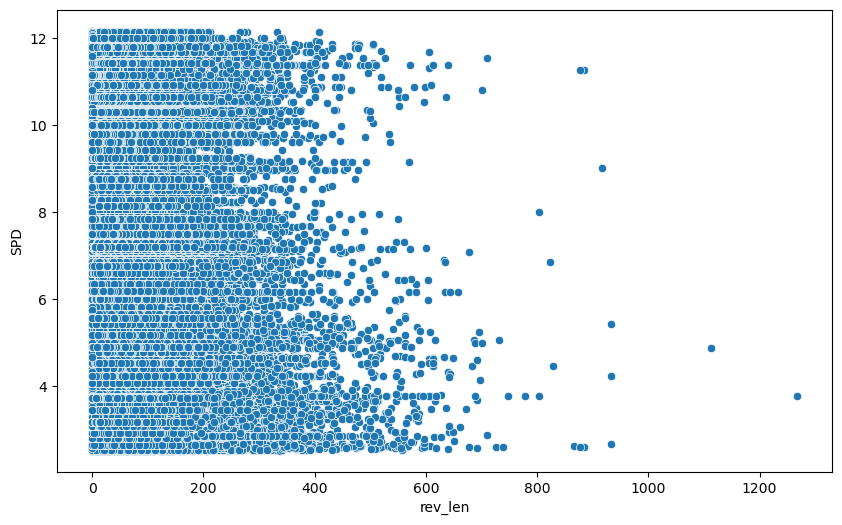

In [1098]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_rev['SPD'], x=product_with_rev['rev_len'])

<AxesSubplot:xlabel='rev_len', ylabel='Final price'>

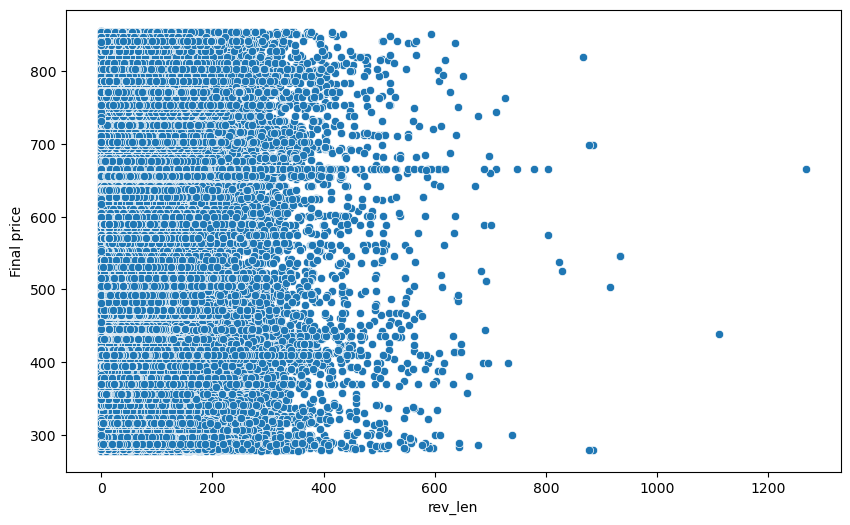

In [1099]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_rev['Final price'], x=product_with_rev['rev_len'])

<AxesSubplot:xlabel='text', ylabel='Base price'>

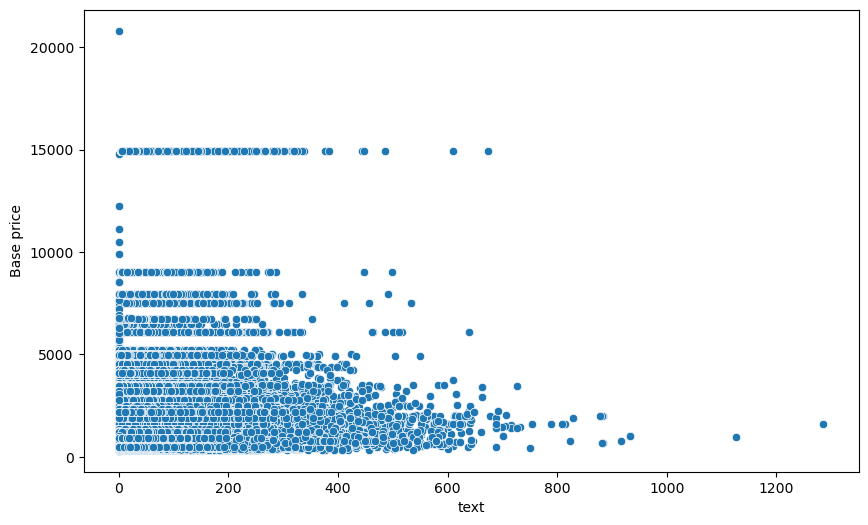

In [761]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_rev['Base price'], x=product_with_rev['text'].apply(lambda x: len(x)))

<AxesSubplot:xlabel='negative', ylabel='Sales'>

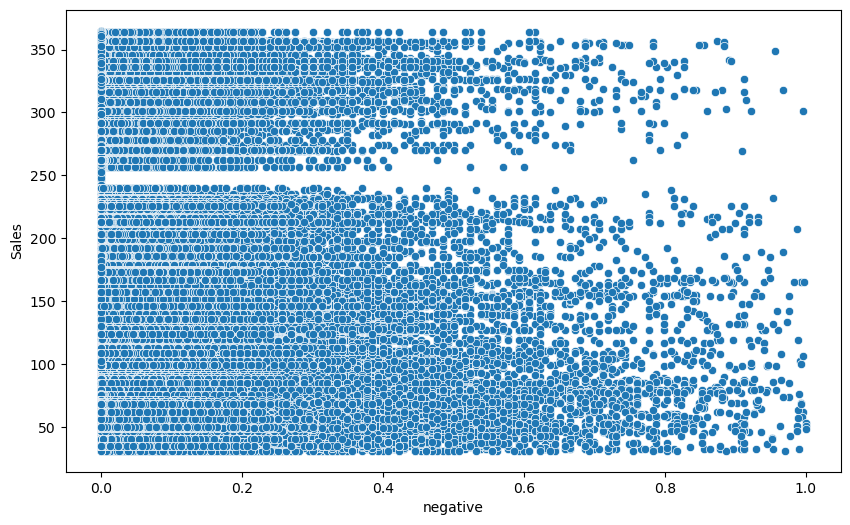

In [762]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_rev['Sales'], x=product_with_rev['negative'])

<AxesSubplot:xlabel='text', ylabel='None'>

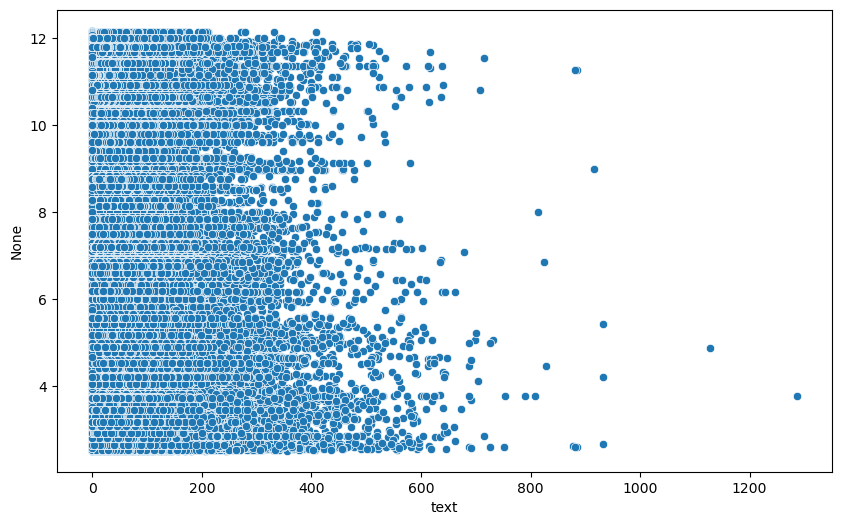

In [763]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_rev['Sales']/product_with_rev['Days in stock'], x=product_with_rev['text'].apply(lambda x: len(x)))

<AxesSubplot:xlabel='text', ylabel='Sales'>

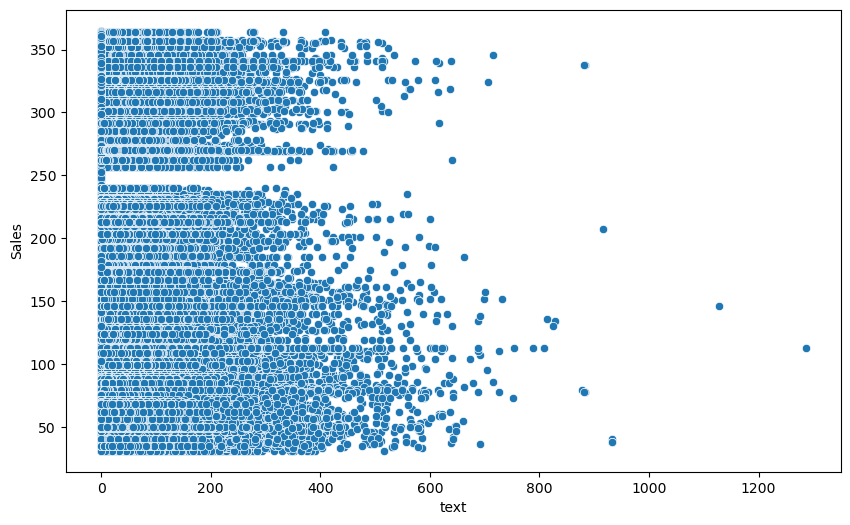

In [764]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_rev['Sales'], x=product_with_rev['text'].apply(lambda x: len(x)))

<AxesSubplot:xlabel='text', ylabel='Sales'>

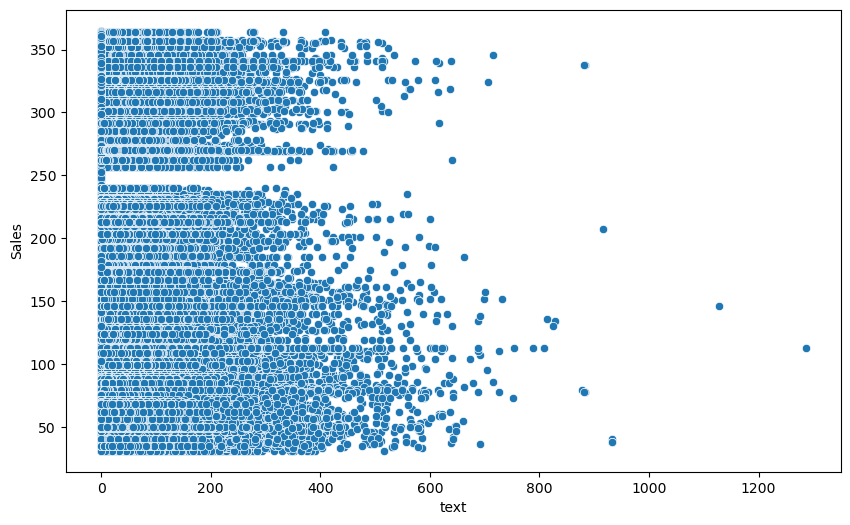

In [765]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_rev['Sales'], x=product_with_rev['text'].apply(lambda x: len(x)))

In [766]:
from scipy.stats import pearsonr

correlation_coef, p_value = pearsonr(product_with_rev['Sales'],product_with_rev['text'].apply(lambda x: len(x)))

print(f"Pearson's correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson's correlation coefficient: 0.053
P-value: 0.000


In [767]:
from scipy.stats import pearsonr

correlation_coef, p_value = pearsonr(y=product_with_rev['Sales'], x=product_with_rev['negative'])

print(f"Pearson's correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson's correlation coefficient: 0.033
P-value: 0.000


In [768]:
from scipy.stats import pearsonr

correlation_coef, p_value = pearsonr(product_with_rev['Final price'],product_with_rev['text'].apply(lambda x: len(x)))

print(f"Pearson's correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson's correlation coefficient: 0.086
P-value: 0.000


In [769]:

correlation_coef, p_value = pearsonr(product_with_rev['Sales']/product_with_rev['Days in stock'],product_with_rev['text'].apply(lambda x: len(x)))

print(f"Pearson's correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson's correlation coefficient: 0.041
P-value: 0.000


<h3>EDA Price Hits</h3>

In [770]:
price_hist = get_price_hist(product['SKU'])

100%|███████████████████████████████████████| 1500/1500 [02:52<00:00,  8.70it/s]


In [771]:
price_hist['date'] = pd.to_datetime(price_hist['date'])


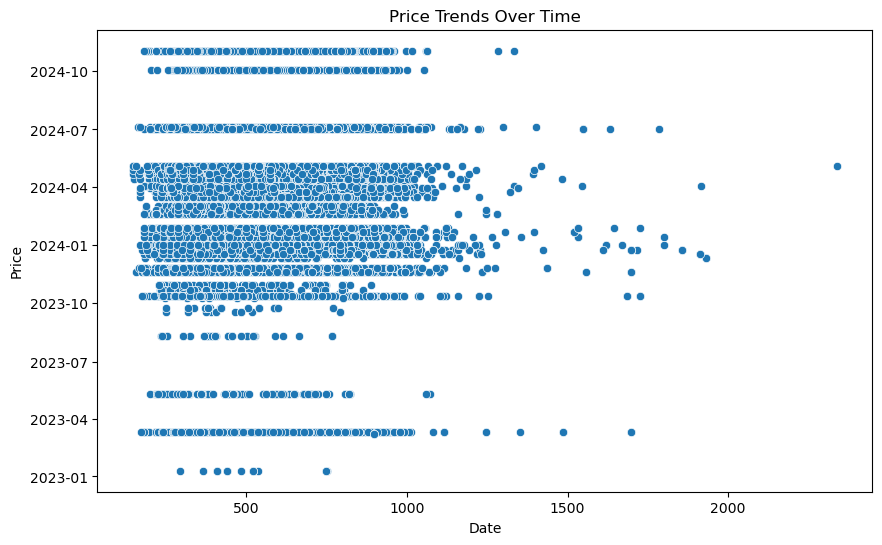

In [772]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting price trends
plt.figure(figsize=(10, 6))
sns.scatterplot(data=price_hist, x='price', y='date')
plt.title('Price Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [775]:
price_hist['SKU'] = price_hist['SKU'].astype(int)
price_hist = price_hist.merge(product[['SPD','SKU']], left_on='SKU',right_on='SKU')
best_selling_ph = price_hist.loc[price_hist['SKU'].isin(best_selling_list)]
average_selling_ph = price_hist.loc[price_hist['SKU'].isin(average_selling_list)]
worst_selling_ph = price_hist.loc[price_hist['SKU'].isin(worst_selling_list)]
price_hist_sum = price_hist.groupby('SKU').count()

<AxesSubplot:xlabel='SPD', ylabel='price'>

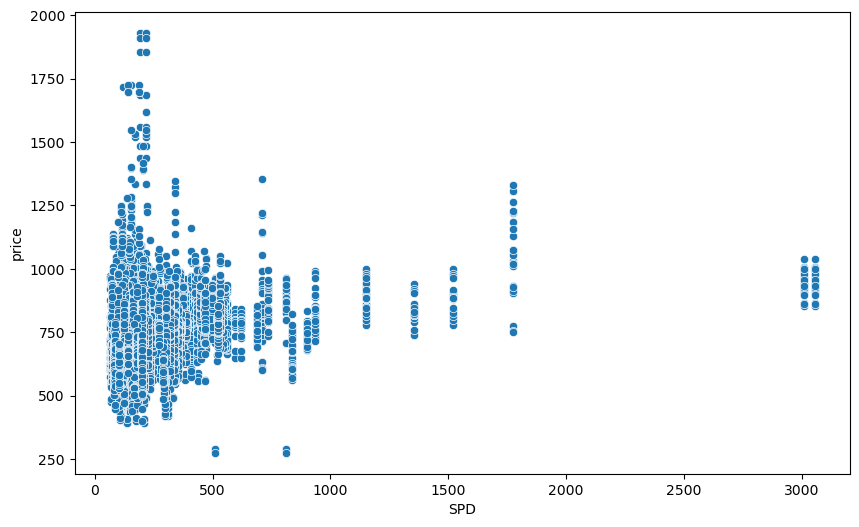

In [778]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=price_hist['price'], x=best_selling_ph['SPD'])

<AxesSubplot:xlabel='SPD', ylabel='price'>

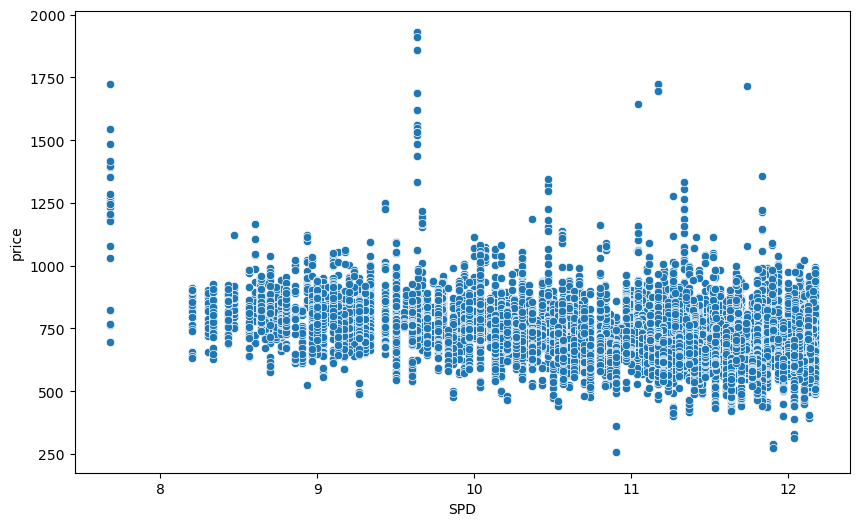

In [782]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=best_selling_ph['price'], x=best_selling_ph['SPD'])

<AxesSubplot:xlabel='SPD', ylabel='price'>

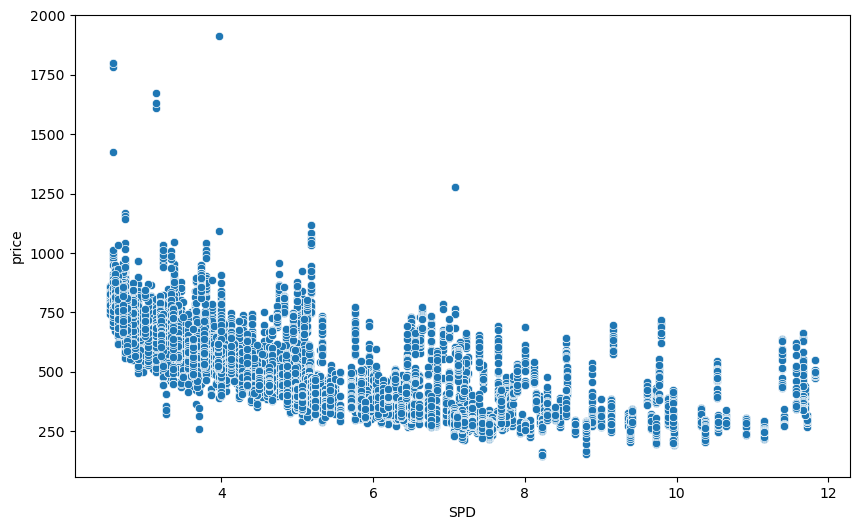

In [783]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=average_selling_ph['price'], x=average_selling_ph['SPD'])

<AxesSubplot:xlabel='SPD', ylabel='price'>

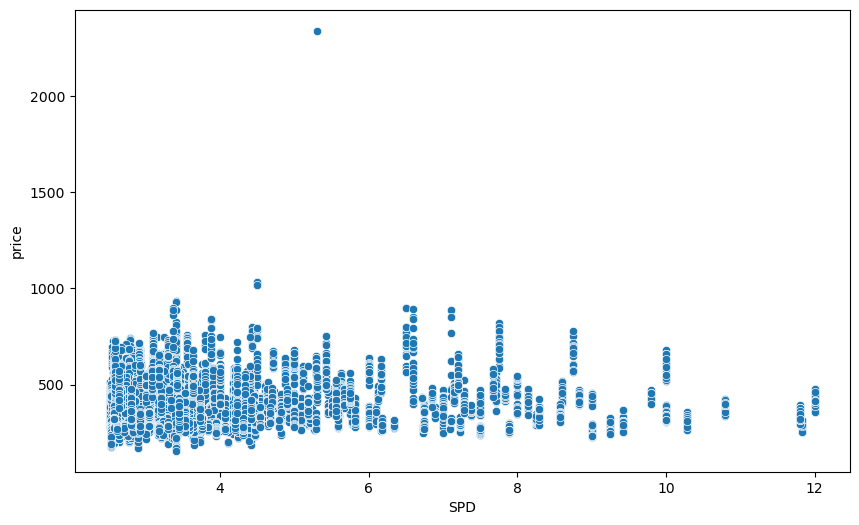

In [784]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=worst_selling_ph['price'], x=worst_selling_ph['SPD'])

<AxesSubplot:xlabel='SPD', ylabel='price'>

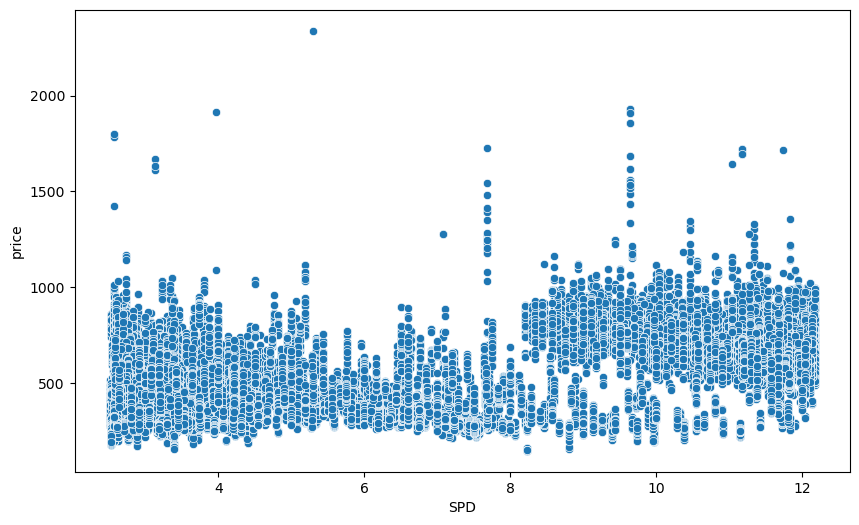

In [785]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=price_hist['price'], x=price_hist['SPD'][price_hist['SPD'] < 2000])

In [786]:
rev = get_rev(product['SKU'])
rev['SKU'] = rev['SKU'].astype(int)
rev['PCT'] = price_hist_sum['price']
product_with_num_rev = product.merge(rev, on = 'SKU',how = 'left')
fef = list(price_hist_sum['SPD'])
product_with_num_rev['CPT'] =fef

100%|███████████████████████████████████████| 1500/1500 [01:40<00:00, 14.86it/s]


In [795]:
while len(fef) < 1500:
    fef.append(1)

<AxesSubplot:xlabel='CPT', ylabel='Sales'>

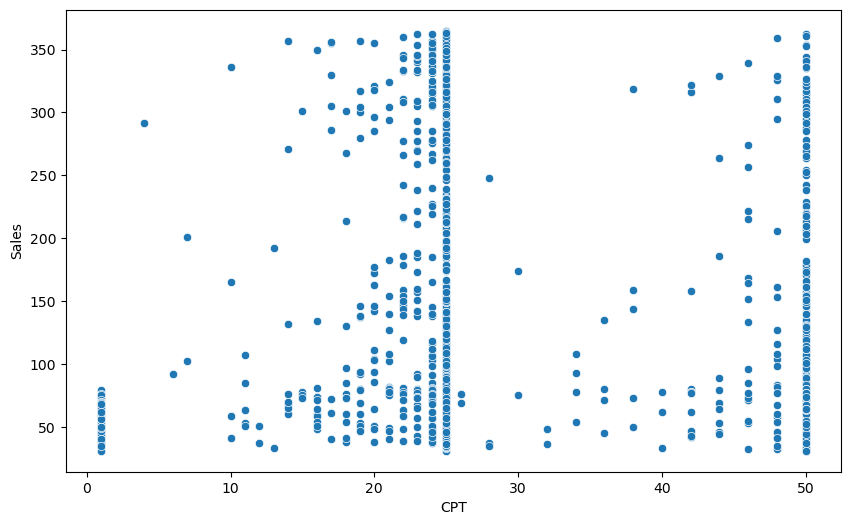

In [798]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_num_rev['Sales'], x=product_with_num_rev['CPT'])

<AxesSubplot:xlabel='CPT', ylabel='SPD'>

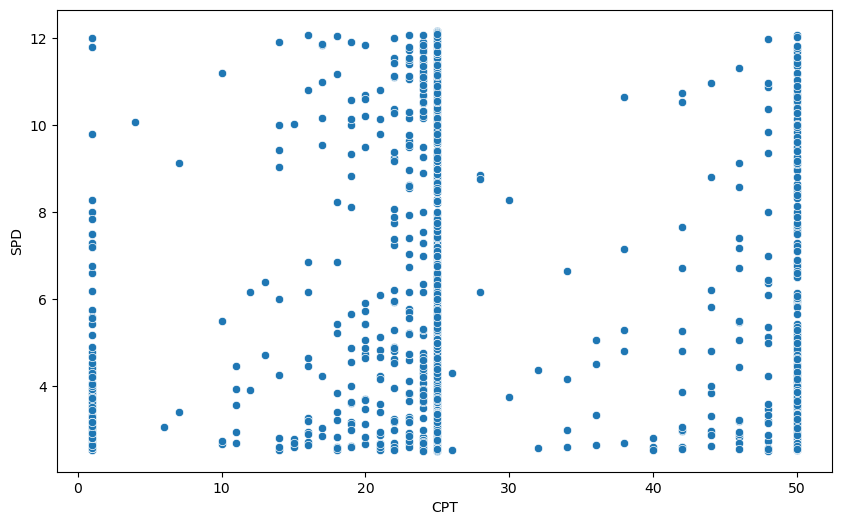

In [799]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_num_rev['SPD'], x=product_with_num_rev['CPT'])

<AxesSubplot:xlabel='num_rev', ylabel='SPD'>

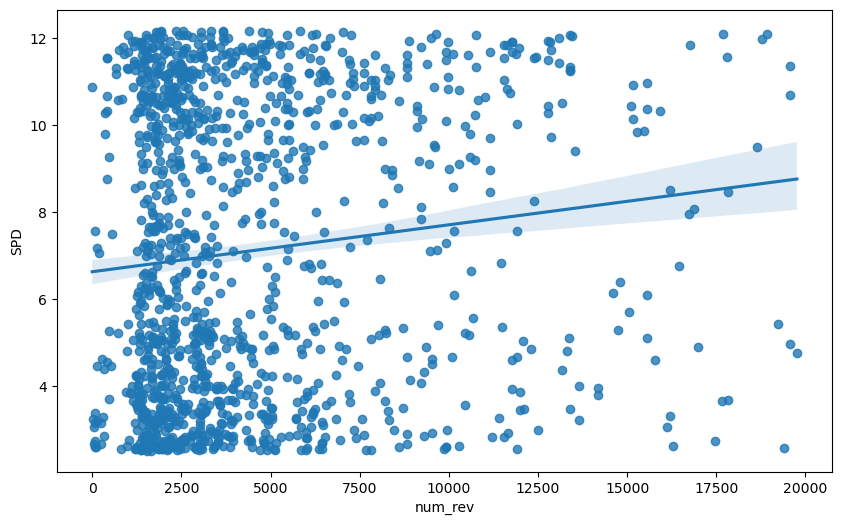

In [1107]:
plt.figure(figsize=(10, 6))
sns.regplot(y=product_with_num_rev['SPD'][:1300], x=product_with_num_rev['num_rev'][product_with_num_rev['num_rev'] <= 20000][:1300])

<AxesSubplot:xlabel='num_prom', ylabel='SPD'>

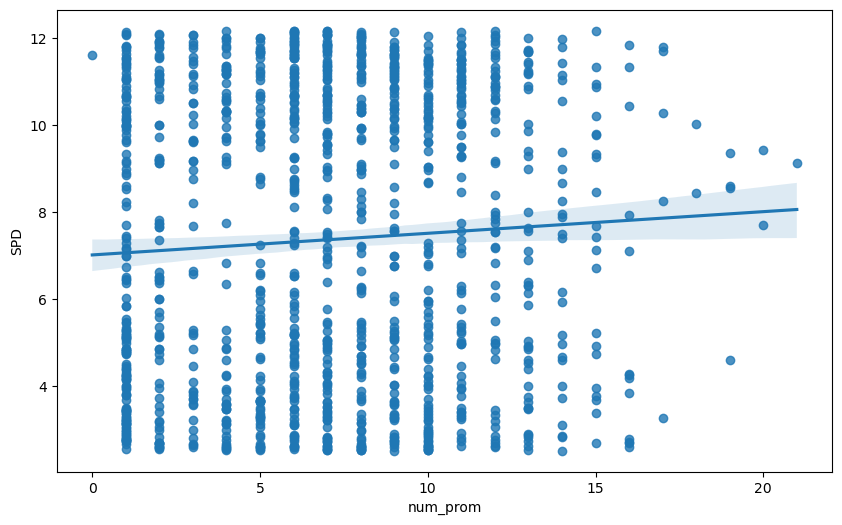

In [948]:
plt.figure(figsize=(10, 6))
sns.regplot(y=product_with_num_rev['SPD'][product_with_num_rev['SPD'] <= 2000][:1200], x=product_with_num_rev['num_prom'][product_with_num_rev['num_prom'] <= 27000][:1200])

<AxesSubplot:xlabel='num_rev', ylabel='Sales'>

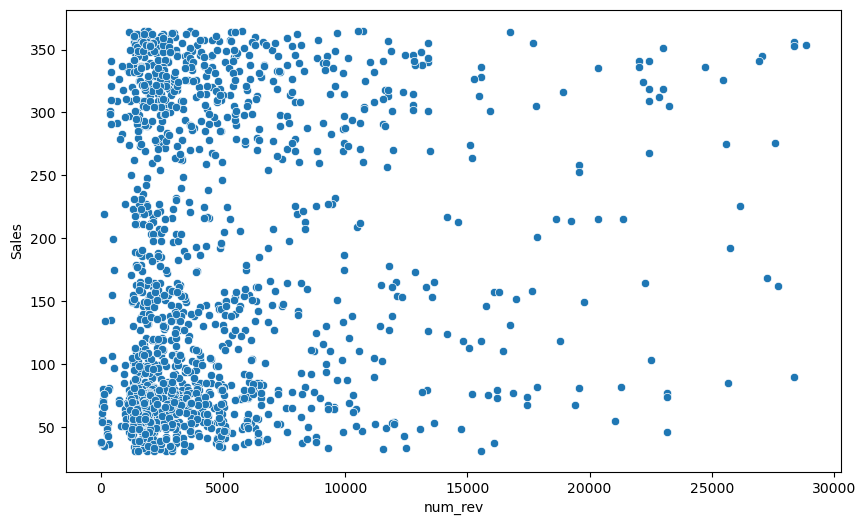

In [802]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=product_with_num_rev['Sales'][product_with_num_rev['Sales']<= 15000], x=product_with_num_rev['num_rev'][product_with_num_rev['num_rev']<= 30000])

<AxesSubplot:xlabel='num_rev', ylabel='Sales'>

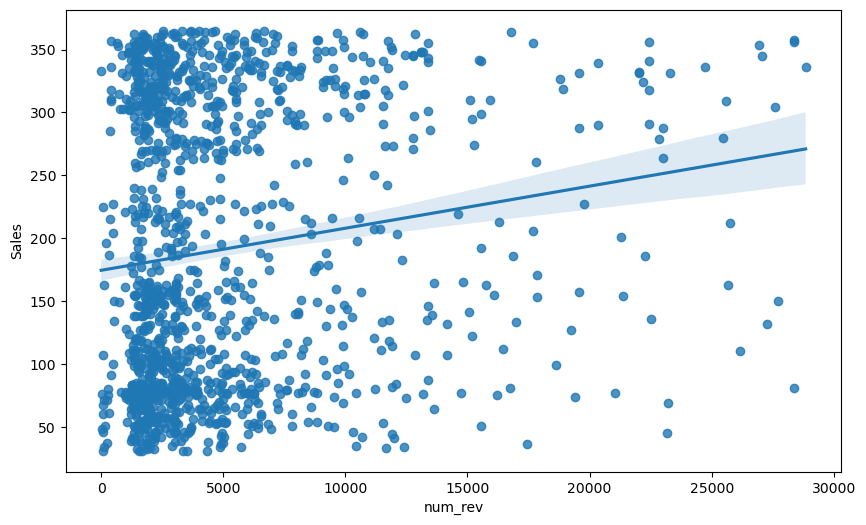

In [1110]:
plt.figure(figsize=(10, 6))
sns.regplot(y=product_with_num_rev['Sales'][:1300], x=product_with_num_rev['num_rev'][product_with_num_rev['num_rev']<= 30000][:1300])

In [803]:
best_selling = product_with_num_rev.loc[product_with_num_rev['SKU'].isin(best_selling_list)]
average_selling = product_with_num_rev.loc[product_with_num_rev['SKU'].isin(average_selling_list)]
worst_selling = product_with_num_rev.loc[product_with_num_rev['SKU'].isin(worst_selling_list)]

<AxesSubplot:xlabel='num_rev', ylabel='Sales'>

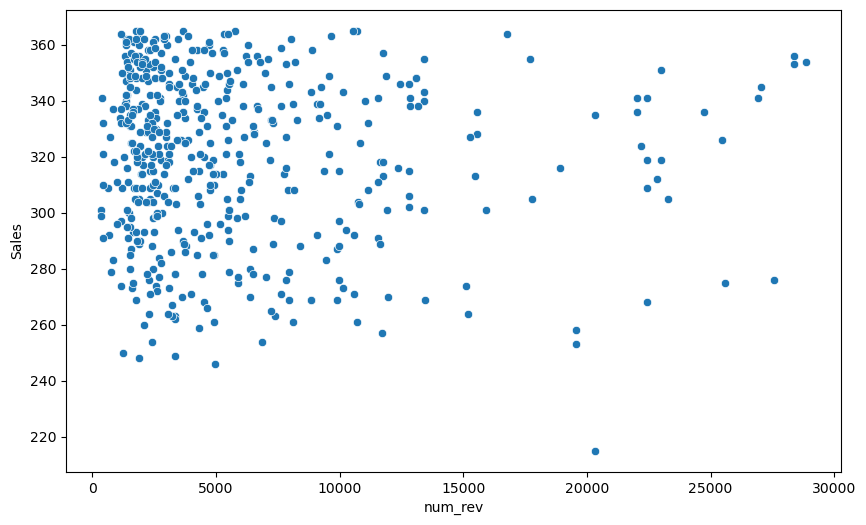

In [804]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=best_selling['Sales'][best_selling['Sales']<= 15000], x=best_selling['num_rev'][best_selling['num_rev']<= 30000])

<AxesSubplot:xlabel='CPT', ylabel='SPD'>

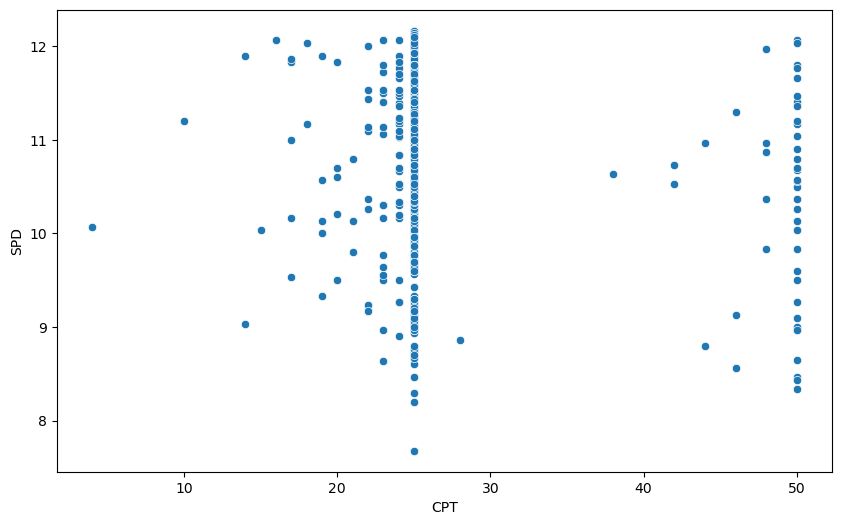

In [805]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=best_selling['SPD'], x=best_selling['CPT'])

<AxesSubplot:xlabel='num_rev', ylabel='Sales'>

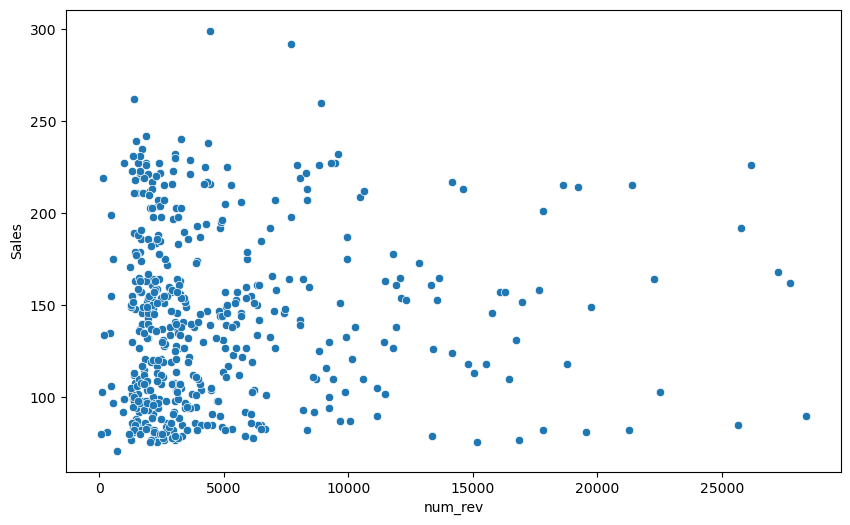

In [806]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=average_selling['Sales'][average_selling['Sales']<= 15000], x=average_selling['num_rev'][average_selling['num_rev']<= 30000])

<AxesSubplot:xlabel='CPT', ylabel='SPD'>

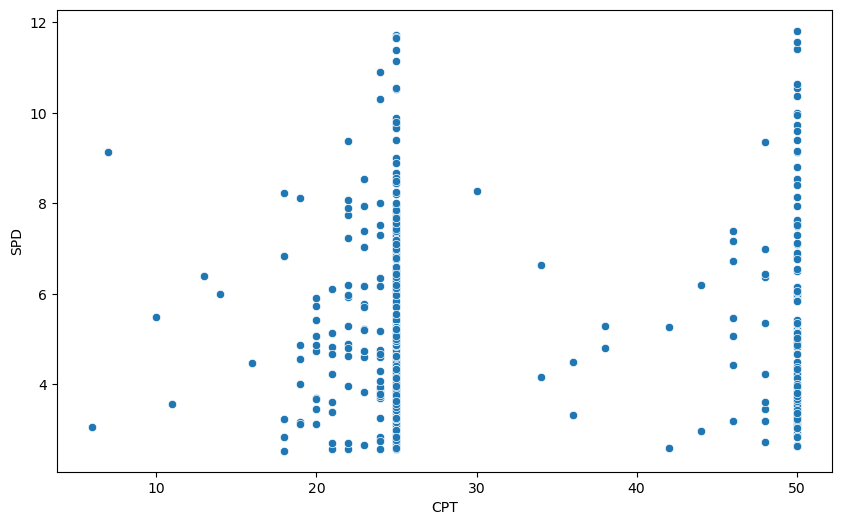

In [807]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=average_selling['SPD'], x=average_selling['CPT'])

<AxesSubplot:xlabel='num_rev', ylabel='Sales'>

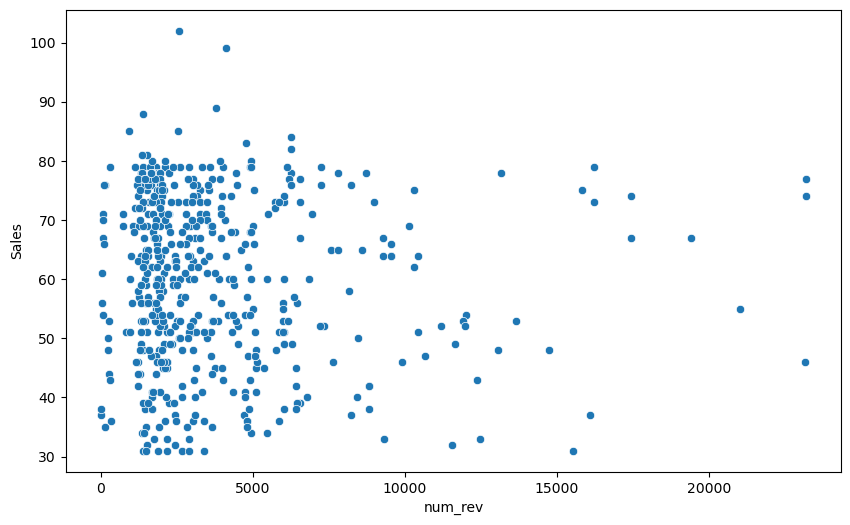

In [808]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=worst_selling['Sales'][worst_selling['Sales']<= 15000], x=worst_selling['num_rev'][worst_selling['num_rev']<= 30000])

<AxesSubplot:xlabel='CPT', ylabel='SPD'>

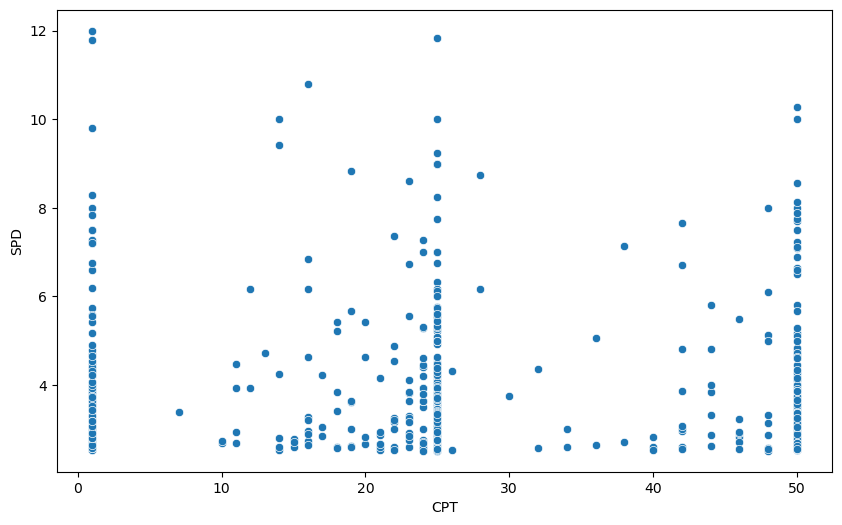

In [809]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y=worst_selling['SPD'], x=worst_selling['CPT'])

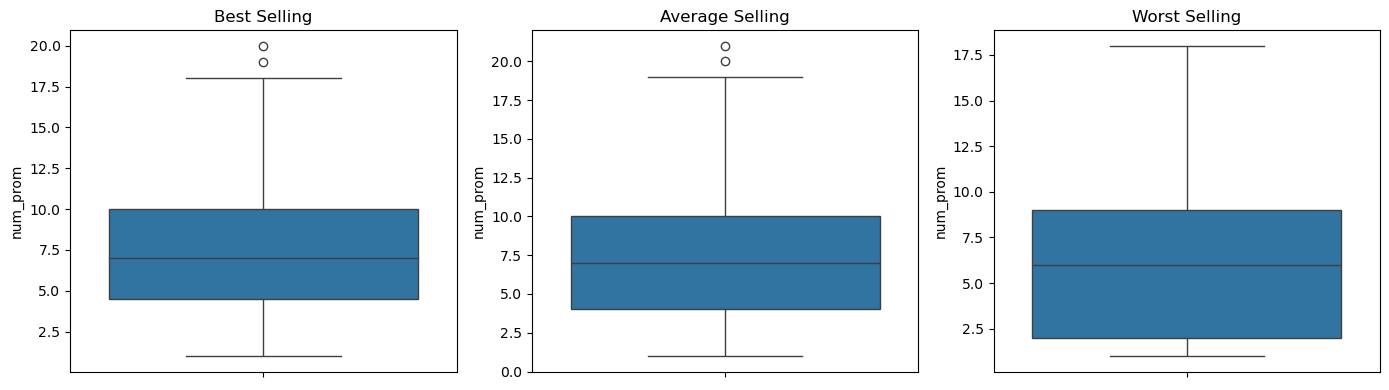

In [810]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

sns.boxplot(data=best_selling['num_prom'], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['num_prom'], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['num_prom'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

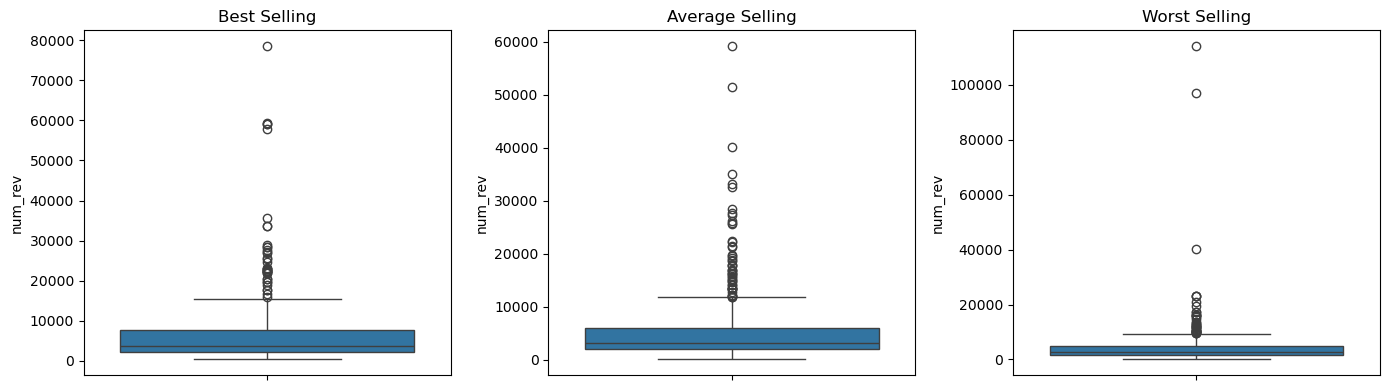

In [811]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

sns.boxplot(data=best_selling['num_rev'], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['num_rev'], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['num_rev'], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

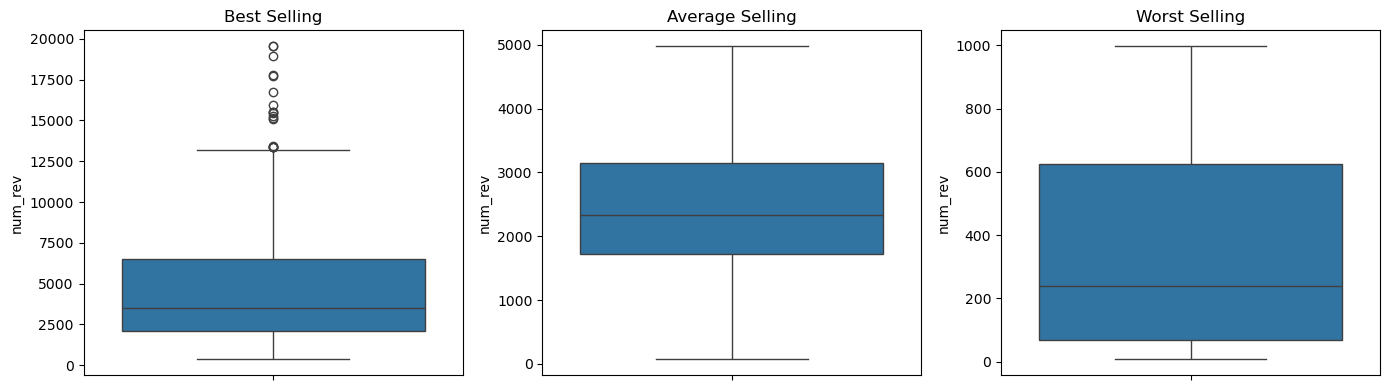

In [812]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  

threshold_best_sales= 20000
threshold_avg_sales= 5000
threshold_worst_sales = 1000

sns.boxplot(data=best_selling['num_rev'][best_selling['num_rev']<= threshold_best_sales], ax=axes[0])
axes[0].set_title('Best Selling')

sns.boxplot(data=average_selling['num_rev'][average_selling['num_rev']<= threshold_avg_sales], ax=axes[1])
axes[1].set_title('Average Selling')

sns.boxplot(data=worst_selling['num_rev'][worst_selling['num_rev']<= threshold_worst_sales], ax=axes[2])
axes[2].set_title('Worst Selling')

plt.tight_layout()
plt.show()

In [813]:
product_with_num_rev['num_rev'] = product_with_num_rev['num_rev'].fillna(0)
product_with_num_rev['num_prom'] = product_with_num_rev['num_prom'].fillna(0)


In [816]:
from scipy.stats import pearsonr

correlation_coef, p_value = pearsonr(product_with_num_rev['num_rev'],product_with_num_rev['SPD'])

print(f"Pearson's correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson's correlation coefficient: 0.117
P-value: 0.000


In [1090]:
from scipy.stats import pearsonr

correlation_coef, p_value = pearsonr(product_with_num_rev['num_prom'],product_with_num_rev['Sales'])

print(f"Pearson's correlation coefficient: {correlation_coef:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson's correlation coefficient: 0.134
P-value: 0.000


<h3>NER</h3>

In [1065]:
product_with_rev = product_with_rev.drop_duplicates()

In [1066]:
len(best_selling_list)

500

In [1067]:
best_selling = product_with_rev.loc[product_with_rev['SKU'].isin(best_selling_list)]
average_selling = product_with_rev.loc[product_with_rev['SKU'].isin(average_selling_list)]
worst_selling = product_with_rev.loc[product_with_rev['SKU'].isin(worst_selling_list)]

In [1068]:
import spacy

# Load the Russian model
nlp = spacy.load('ru_core_news_md')

# Dictionary to hold entities and their counts
entities = {}

# Process each review
for review in best_selling['text']:
    doc = nlp(review)
    for ent in doc.ents:
        if ent.label_ in ["LOC",
        "MISC",
        "ORG",
        "PER"]:  # You might filter specific types of entities
            entities[ent.text] = entities.get(ent.text, 0) + 1



In [1069]:
import json
with open('best_selling_entities.json', 'w', encoding='utf8') as fp:
    json.dump(entities, fp,ensure_ascii=False)

In [1070]:
sorted_entities = sorted(entities.items(), key=lambda x: x[1], reverse=True)

# Print the most popular entities
print("Most popular entities:")
for entity, freq in sorted_entities[:30]:  # Adjust the slice for more or fewer entities
    print(f"{entity}: {freq}")

Most popular entities:
упакова: 1943
фот: 801
доставк: 389
удобн: 290
диффузор: 262
качествен: 238
тонк: 223
тк: 187
общ: 184
пришл упакова: 170
мо: 169
куп: 150
бер: 148
сер: 141
держ: 141
пришл: 133
копилк: 120
отз: 116
продавц: 115
перв: 105
соответств: 103
пряж: 99
разочарова: 93
окн: 91
бел: 86
аккуратн упакова: 85
порадова: 84
запакова: 79
пользова: 79
бер перв: 76


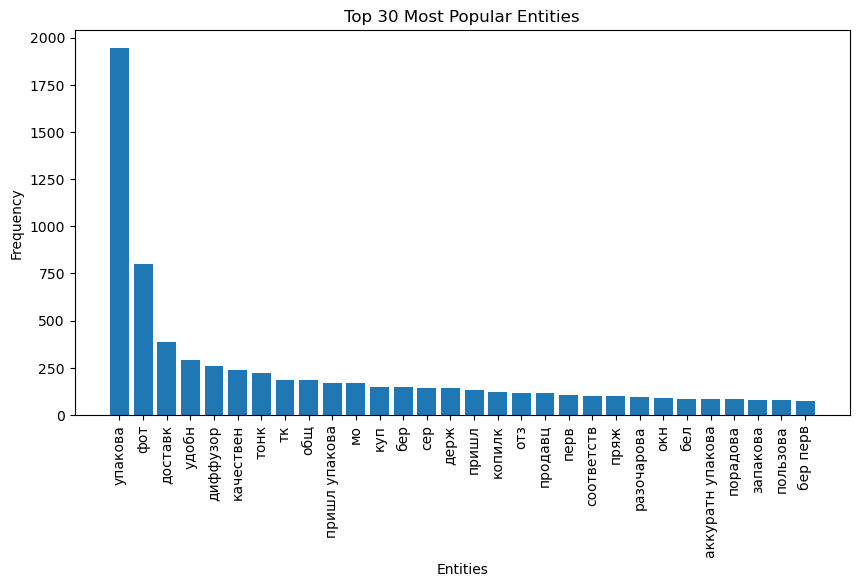

In [1071]:
# Prepare data for plotting
labels, values = zip(*sorted_entities[:30])  # Top 10 entities

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.xlabel('Entities')
plt.ylabel('Frequency')
plt.title('Top 30 Most Popular Entities')
plt.xticks(rotation=90)
plt.show()

In [1072]:
# Dictionary to hold entities and their counts
entities_as = {}

# Process each review
for review in average_selling['text']:
    doc = nlp(review)
    for ent in doc.ents:
        if ent.label_ in ["LOC",
        "MISC",
        "ORG",
        "PER"]:  # You might filter specific types of entities
            entities_as[ent.text] = entities_as.get(ent.text, 0) + 1

In [1073]:
import json
with open('avg_selling_entities.json', 'w', encoding='utf8') as fp:
    json.dump(entities_as, fp,ensure_ascii=False)

In [1074]:
sorted_entities = sorted(entities_as.items(), key=lambda x: x[1], reverse=True)

# Print the most popular entities
print("Most popular entities:")
for entity, freq in sorted_entities[:30]:  # Adjust the slice for more or fewer entities
    print(f"{entity}: {freq}")

Most popular entities:
упакова: 5773
фот: 2943
доставк: 1456
удобн: 1327
краск: 1262
качествен: 958
пряж: 956
тк: 668
мо: 625
соответств: 604
куп: 553
тонк: 531
пришл упакова: 509
бер: 507
общ: 486
пришл: 445
вещ: 421
ещ: 397
перв: 391
продавц: 376
бер перв: 370
порадова: 358
отз: 353
сер: 329
пользова: 322
аккуратн упакова: 314
пробова: 311
разочарова: 284
использова: 272
рисова: 271


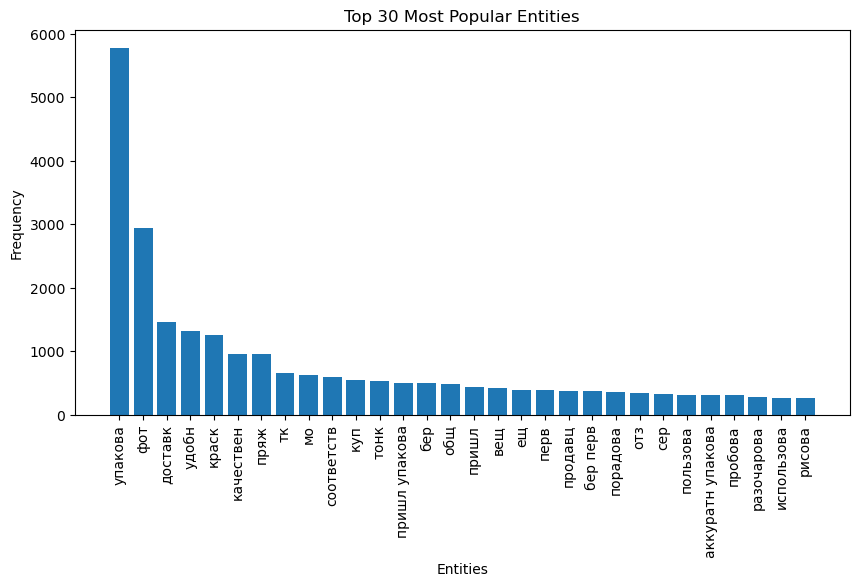

In [1075]:
# Prepare data for plotting
labels, values = zip(*sorted_entities[:30])  # Top 10 entities

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.xlabel('Entities')
plt.ylabel('Frequency')
plt.title('Top 30 Most Popular Entities')
plt.xticks(rotation=90)
plt.show()

In [1077]:
# Dictionary to hold entities and their counts
entities_ws = {}

# Process each review
for review in worst_selling['text']:
    doc = nlp(review)
    for ent in doc.ents:
        if ent.label_ in ["LOC",
        "MISC",
        "ORG",
        "PER"]:  # You might filter specific types of entities
            entities_ws[ent.text] = entities_ws.get(ent.text, 0) + 1

In [1078]:
import json
with open('worst_selling_entities.json', 'w', encoding='utf8') as fp:
    json.dump(entities_ws, fp,ensure_ascii=False)

In [1079]:
sorted_entities = sorted(entities_ws.items(), key=lambda x: x[1], reverse=True)

# Print the most popular entities
print("Most popular entities:")
for entity, freq in sorted_entities[:30]:  # Adjust the slice for more or fewer entities
    print(f"{entity}: {freq}")

Most popular entities:
упакова: 5355
фот: 3057
пряж: 1646
доставк: 1472
удобн: 1245
качествен: 1094
соответств: 841
тк: 584
тонк: 567
бер: 559
бер перв: 552
краск: 544
мо: 536
куп: 490
пришл упакова: 423
ещ: 412
пришл: 399
продавц: 369
перв: 358
аккуратн упакова: 355
общ: 340
порадова: 327
ткан: 307
отз: 303
вещ: 299
сер: 298
красив качествен: 285
использова: 263
копилк: 257
пробова: 256


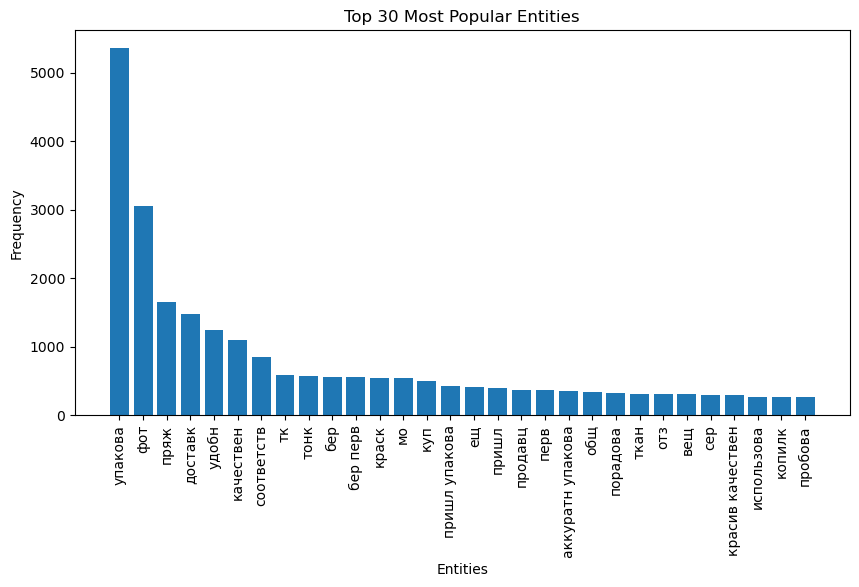

In [1080]:
# Prepare data for plotting
labels, values = zip(*sorted_entities[:30])  # Top 10 entities

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.xlabel('Entities')
plt.ylabel('Frequency')
plt.title('Top 30 Most Popular Entities')
plt.xticks(rotation=90)
plt.show()

<h3>BoW</h3>

In [817]:
vectorizer = CountVectorizer(max_features=2000)

In [818]:
product_with_rev


index        SKU                                               Name  \
0            0  163672308  Чешский бисер набор для бисероплетения Творчес...   
1            1   59338903  Фильтр для воды кувшин для воды Барьер Гранд Н...   
2            2   35891112              Сближающая игра для родителей и детей   
3            3   35778724               Обувница в прихожую закрытая высокая   
4            4  149905284         Вешалка напольная для одежды металлическая   
...        ...        ...                                                ...   
366039  992122   26476378               Копилка для денег деревянная большая   
366040  992123   26476378               Копилка для денег деревянная большая   
366041  992124   26476378               Копилка для денег деревянная большая   
366042  992125   26476378               Копилка для денег деревянная большая   
366043  992126   26476378               Копилка для денег деревянная большая   

        Revenue  Revenue average       Color  \
0        326033      108677667.0   салатовый   
1        307424      102474667.0       белый   
2        303729         101243.0       белый   
3        302654      100884667.0      черный   
4        302562         100854.0       белый   
...         ...              ...         ...   
366039    19490        6496667.0  коричневый   
366040    19490        6496667.0  коричневый   
366041    19490        6496667.0  коричневый   
366042    19490        6496667.0  коричневый   
366043    19490        6496667.0  коричневый   

                                                 Category  Category Position  \
0       Дом/Досуг и творчество/Творчество и рукоделие/...                153   
1       Дом/Хозяйственные товары/Кухня/Аксессуары/Филь...                 51   
2       Дом/Досуг и творчество/Настольные игры/Настоль...                312   
3                            Дом/Прихожая/Мебель/Обувница                 22   
4            Дом/Хранение вещей/Вешалки/Вешалка напольная                  4   
...                                                   ...                ...   
366039                   Дом/Сувенирная продукция/Копилка                 -1   
366040                   Дом/Сувенирная продукция/Копилка                 -1   
366041                   Дом/Сувенирная продукция/Копилка                 -1   
366042                   Дом/Сувенирная продукция/Копилка                 -1   
366043                   Дом/Сувенирная продукция/Копилка                 -1   

               Brand                          Seller  ...          mid  \
0               ХOME  ИП Жиленков Евгений Валерьевич  ...   63133426.0   
1             БАРЬЕР                        ООО Райт  ...   10151663.0   
2       Я тебя слышу                  ИП Маряева О А  ...   26944975.0   
3           Domiland                  ИП Семенов Д В  ...   26856585.0   
4             abcAge             Качественные Товары  ...  172138402.0   
...              ...                             ...  ...          ...   
366039    BlueBird64   ИП Бурмистров Василий Юрьевич  ...   19436240.0   
366040    BlueBird64   ИП Бурмистров Василий Юрьевич  ...   19436240.0   
366041    BlueBird64   ИП Бурмистров Василий Юрьевич  ...   19436240.0   
366042    BlueBird64   ИП Бурмистров Василий Юрьевич  ...   19436240.0   
366043    BlueBird64   ИП Бурмистров Василий Юрьевич  ...   19436240.0   

        Unnamed: 0                                               text  \
0              NaN                                                      
1              NaN                                                      
2              NaN                                                      
3              NaN                                                      
4              NaN                                                      
...            ...                                                ...   
366039       495.0                             хорош копилк пришл цел   
366040       496.0  красив больш вмес

In [980]:
BoW_Matrix = vectorizer.fit_transform(product_with_rev['text'])


In [981]:
vectorizer.get_feature_names_out()

array(['абсолютн', 'адекватн', 'аж', ..., 'ярч', 'ячейк', 'ящик'],
      dtype=object)

In [983]:
bow_df=pd.DataFrame.sparse.from_spmatrix(BoW_Matrix,columns=vectorizer.get_feature_names_out()) 

In [987]:
reduce_columns(bow_df)

абсолютн  аж  акварел  аккуратн  акрилов  альб  альбом  аромат  \
0              0   0        0         0        0     0       0       0   
1              0   0        0         0        0     0       0       0   
2              0   0        0         0        0     0       0       0   
3              0   0        0         0        0     0       0       0   
4              0   0        0         0        0     0       0       0   
...          ...  ..      ...       ...      ...   ...     ...     ...   
366039         0   0        0         0        0     0       0       0   
366040         0   0        0         0        0     0       0       0   
366041         0   0        0         0        0     0       0       0   
366042         0   0        0         0        0     0       0       0   
366043         0   0        0         0        0     0       0       0   

        ароматн  артикул  ...  эстетичн  эт  этикетк  эффект  юбк  явн  ярк  \
0             0        0  ...         0   0        0       0    0    0    0   
1             0        0  ...         0   0        0       0    0    0    0   
2             0        0  ...         0   0        0       0    0    0    0   
3             0        0  ...         0   0        0       0    0    0    0   
4             0        0  ...         0   0        0       0    0    0    0   
...         ...      ...  ...       ...  ..      ...     ...  ...  ...  ...   
366039        0        0  ...         0   0        0       0    0    0    0   
366040        0        0  ...         0   0        0       0    0    0    0   
366041        0        0  ...         0   0        0       0    0    0    0   
366042        0        0  ...         0   0        0       0    0    0    0   
366043        0        0  ...         0   0        0       0    0    0    0   

        ярч  ячейк  ящик  
0         0      0     0  
1         0      0     0  
2         0      0     0  
3         0      0     0  
4         0      0     0  
...     ...    ...   ...  
366039    0      0     0  
366040    0      0     0  
366041    0      0     0  
366042    0      0     0  
366043    0      0     0  

[366044 rows x 1737 columns]

In [820]:
combined_matrix = hstack([BoW_Matrix,product_with_rev[['positive','neutral','negative']]])

In [821]:
BoW_Matrix

<366044x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 2484655 stored elements in Compressed Sparse Row format>

In [986]:
def reduce_columns(df):
    n_docs = df.astype(bool).sum(axis=0)
    cols_to_keep = n_docs[n_docs > 0.0005 * df.shape[0]].index
    return df[cols_to_keep]

In [823]:
from collections import Counter

def reducecolumns(Col):
    n_docs = Counter(Col.nonzero()[1])
    cols_to_keep = [k for k, v in n_docs.items() if v > .0005 * Col.shape[0]]
    return Col[:, cols_to_keep]

In [988]:
BoW_Matrix = reducecolumns(BoW_Matrix)

In [989]:
BoW_Matrix

<366044x1737 sparse matrix of type '<class 'numpy.int64'>'
	with 2441806 stored elements in Compressed Sparse Row format>

In [991]:
pd.DataFrame.sparse.from_spmatrix(final_mat) 

0      1     2     3     4     5     6      7     8     9     ...  \
0     19.0   54.0   1.0   0.0  10.0   2.0   0.0  172.0   1.0   0.0  ...   
1      0.0    0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   0.0  ...   
2      0.0    0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   0.0  ...   
3      0.0    0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   0.0  ...   
4      0.0    0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   0.0  ...   
...    ...    ...   ...   ...   ...   ...   ...    ...   ...   ...  ...   
1495  27.0  105.0   0.0   0.0  15.0   3.0   3.0  178.0   5.0   0.0  ...   
1496   0.0    0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   0.0  ...   
1497   0.0    0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   0.0  ...   
1498   5.0   90.0   0.0   0.0   3.0   2.0   1.0   88.0   5.0   0.0  ...   
1499   0.0    0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   0.0  ...   

          3034      3035      3036      3037      3038      3039    3040  \
0     0.052106 -0.031947  0.009792 -0.074523  0.050264  0.083218  8874.0   
1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  9649.0   
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1335.0   
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  7002.0   
4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  2537.0   
...        ...       ...       ...       ...       ...       ...     ...   
1495  0.049260 -0.030967  0.009748 -0.078419  0.051897  0.085488  8820.0   
1496  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  2678.0   
1497  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  2275.0   
1498  0.047961 -0.028598  0.011349 -0.075619  0.049152  0.081574  4814.0   
1499  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  2609.0   

      3041  3042   3043  
0      6.0  25.0  853.0  
1      2.0  25.0  841.0  
2     12.0  25.0  843.0  
3     13.0  25.0  843.0  
4      7.0  25.0  779.0  
...    ...   ...    ...  
1495   8.0   1.0  515.0  
1496   5.0   1.0  492.0  
1497   7.0   1.0  287.0  
1498   1.0   1.0  570.0  
1499  11.0   1.0  505.0  

[1500 rows x 3044 columns]

In [826]:
bow_df=pd.DataFrame.sparse.from_spmatrix(BoW_Matrix) 

In [827]:
bow_df

0     1     2     3     4     5     6     7     8     9     ...  1727  \
0          0     0     0     0     0     0     0     0     0     0  ...     0   
1          0     0     0     0     0     0     0     0     0     0  ...     0   
2          0     0     0     0     0     0     0     0     0     0  ...     0   
3          0     0     0     0     0     0     0     0     0     0  ...     0   
4          0     0     0     0     0     0     0     0     0     0  ...     0   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
366039     0     1     0     0     0     0     0     0     0     0  ...     0   
366040     0     0     0     0     0     0     0     0     0     0  ...     0   
366041     0     0     0     0     0     0     0     0     0     0  ...     0   
366042     0     0     0     0     0     0     0     0     0     1  ...     0   
366043     0     0     0     0     0     0     0     0     0     0  ...     0   

        1728  1729  1730  1731  1732  1733  1734  1735  1736  
0          0     0     0     0     0     0     0     0     0  
1          0     0     0     0     0     0     0     0     0  
2          0     0     0     0     0     0     0     0     0  
3          0     0     0     0     0     0     0     0     0  
4          0     0     0     0     0     0     0     0     0  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
366039     0     0     0     0     0     0     0     0     0  
366040     0     0     0     0     0     0     0     0     0  
366041     0     0     0     0     0     0     0     0     0  
366042     0     0     0     0     0     0     0     0     0  
366043     0     0     0     0     0     0     0     0     0  

[366044 rows x 1737 columns]

In [993]:
bow_df['SKU']= product_with_rev['SKU']

In [994]:
bow_df_mean = bow_df.groupby('SKU').sum()

In [995]:
bow_df_mean

абсолютн  адекватн  аж  акварел  аккуратн  акрилов  альб  альбом  \
SKU                                                                           
2472313           1         0   1        0        14        0     0       0   
2812202           0         0   0        0         0        0     0       0   
3713040           0         0   0        0         0        0     0       0   
4031690           0         0   0        0         0        0     0       0   
4114830           0         0   0        0         0        0     0       0   
...             ...       ...  ..      ...       ...      ...   ...     ...   
209893907         0         0   0        0        14        0     0       0   
210345571         0         0   0        0         0        0     0       0   
210361104         0         0   0        0         0        0     0       0   
210911023         0         0   0        0         5        0     0       0   
211261831         0         0   0        0         0        0     0       0   

           аромат  ароматизатор  ...  этикетк  эффект  эффектн  юбк  юл  явн  \
SKU                              ...                                           
2472313         0             0  ...        1       0        1    0   0    3   
2812202         0             0  ...        0       0        0    0   0    0   
3713040         0             0  ...        0       0        0    0   0    0   
4031690         0             0  ...        0       0        0    0   0    0   
4114830         0             0  ...        0       0        0    0   0    0   
...           ...           ...  ...      ...     ...      ...  ...  ..  ...   
209893907       0             0  ...        0       0        0    0   0    2   
210345571       0             0  ...        0       0        0    0   0    0   
210361104       0             0  ...        0       0        0    0   0    0   
210911023       0             0  ...        0       0        0    0   0    0   
211261831       0             0  ...        0       0        0    0   0    0   

           ярк  ярч  ячейк  ящик  
SKU                               
2472313      0    0      0     0  
2812202      0    0      0     0  
3713040      0    0      0     0  
4031690      0    0      0     0  
4114830      0    0      0     0  
...        ...  ...    ...   ...  
209893907    2    0      1     1  
210345571    0    0      0     0  
210361104    0    0      0     0  
210911023    0    0      0     0  
211261831    0    0      0     0  

[1500 rows x 2000 columns]

In [996]:
len(bow_df['SKU'].unique())

1500

In [832]:
bow_df_mean

0     1     2     3     4     5     6     7     8     9     ...  \
SKU                                                                    ...   
2472313      19    54     1     0    10     2     0   172     1     0  ...   
2812202       0     0     0     0     0     0     0     0     0     0  ...   
3713040       0     0     0     0     0     0     0     0     0     0  ...   
4031690       0     0     0     0     0     0     0     0     0     0  ...   
4114830       0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
209893907    27   105     0     0    15     3     3   178     5     0  ...   
210345571     0     0     0     0     0     0     0     0     0     0  ...   
210361104     0     0     0     0     0     0     0     0     0     0  ...   
210911023     5    90     0     0     3     2     1    88     5     0  ...   
211261831     0     0     0     0     0     0     0     0     0     0  ...   

           1727  1728  1729  1730  1731  1732  1733  1734  1735  1736  
SKU                                                                    
2472313       0     0     0     0     0     0     0     0     0     0  
2812202       0     0     0     0     0     0     0     0     0     0  
3713040       0     0     0     0     0     0     0     0     0     0  
4031690       0     0     0     0     0     0     0     0     0     0  
4114830       0     0     0     0     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
209893907     0     0     0     0     0     0     0     0     0     0  
210345571     0     0     0     0     0     0     0     0     0     0  
210361104     0     0     0     0     0     0     0     0     0     0  
210911023     0     0     0     0     0     0     0     0     0     0  
211261831     0     0     0     0     0     0     0     0     0     0  

[1500 rows x 1737 columns]

In [833]:
import scipy

In [997]:

bow_mat_grouped = scipy.sparse.csr_matrix(bow_df_mean.values)

In [835]:
scipy.sparse.save_npz('bow_mat_grouped2.npz', bow_mat_grouped)

In [525]:
from scipy import sparse


In [64]:
bow_mat_grouped = sparse.load_npz('bow_mat_grouped.npz')

In [66]:
bow_mat_grouped_df =  pd.DataFrame.sparse.from_spmatrix(bow_mat_grouped)

In [559]:
bow_df_mean.to_csv('bow_mean2.csv')

In [836]:
target = product['SPD']

In [837]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeDeleter(BaseEstimator, TransformerMixin):
    def __init__(self, delete=True):
        self.delete = delete
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.delete(X,[fire.columns.get_loc(i) for i in['X','Y','area']],axis=1)

In [838]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('drop_attributes', AttributeDeleter()),
                         ('std_scaler', StandardScaler()),
                        ])

In [1154]:
X = bow_df_mean
y = product[['SPD','SKU']]

In [840]:
   
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn import datasets, linear_model, metrics 
import pandas as pd

In [841]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [842]:
import requests
import numpy as np
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import math
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,model_selection,linear_model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import catboost as ctb
from nltk.stem.porter import PorterStemmer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter
from scipy.sparse import csr_matrix, hstack

import warnings
warnings.filterwarnings("ignore")

In [843]:
from collections import Counter

def reducecolumns(Col):
    n_docs = Counter(Col.nonzero()[1])
    cols_to_keep = [k for k, v in n_docs.items() if v > .0005 * Col.shape[0]]
    return Col[:, cols_to_keep]

In [1174]:
def get_model_scores(model,X_test,y_test):
    
    #Возвращает значение MAPE для полученной модели
    y_pred = model.predict(X_test)
    print(f'[RMSE:{rmse(y_pred,y_test)}]')
    print(f'[MAPE:{mean_absolute_percentage_error(y_pred,y_train)}]')
    return model

In [1129]:
X = tf_idf_g

In [1138]:
X = w2v_df_mean

In [1180]:
final_mat_df

0    1    2    3     4    5    6    7    8    9  ...      3298  \
0     1.0  0.0  1.0  0.0  14.0  0.0  0.0  0.0  0.0  0.0  ... -0.031947   
1     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
2     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
3     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
4     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
...   ...  ...  ...  ...   ...  ...  ...  ...  ...  ...  ...       ...   
1495  0.0  0.0  0.0  0.0  14.0  0.0  0.0  0.0  0.0  0.0  ... -0.030967   
1496  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
1497  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
1498  0.0  0.0  0.0  0.0   5.0  0.0  0.0  0.0  0.0  0.0  ... -0.028598   
1499  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   

          3299      3300      3301      3302    3303  3304  3305   3306  \
0     0.009792 -0.074523  0.050264  0.083218  8874.0   6.0  25.0  853.0   
1     0.000000  0.000000  0.000000  0.000000  9649.0   2.0  25.0  841.0   
2     0.000000  0.000000  0.000000  0.000000  1335.0  12.0  25.0  843.0   
3     0.000000  0.000000  0.000000  0.000000  7002.0  13.0  25.0  843.0   
4     0.000000  0.000000  0.000000  0.000000  2537.0   7.0  25.0  779.0   
...        ...       ...       ...       ...     ...   ...   ...    ...   
1495  0.009748 -0.078419  0.051897  0.085488  8820.0   8.0   1.0  515.0   
1496  0.000000  0.000000  0.000000  0.000000  2678.0   5.0   1.0  492.0   
1497  0.000000  0.000000  0.000000  0.000000  2275.0   7.0   1.0  287.0   
1498  0.011349 -0.075619  0.049152  0.081574  4814.0   1.0   1.0  570.0   
1499  0.000000  0.000000  0.000000  0.000000  2609.0  11.0   1.0  505.0   

            SKU  
0     163672308  
1      59338903  
2      35891112  
3      35778724  
4     149905284  
...         ...  
1495   27291662  
1496   46070294  
1497   43873174  
1498   44039530  
1499   26476378  

[1500 rows x 3308 columns]

In [1182]:
X

0    1    2    3     4    5    6    7    8    9  ...      3298  \
0     1.0  0.0  1.0  0.0  14.0  0.0  0.0  0.0  0.0  0.0  ... -0.031947   
1     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
2     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
3     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
4     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
...   ...  ...  ...  ...   ...  ...  ...  ...  ...  ...  ...       ...   
1495  0.0  0.0  0.0  0.0  14.0  0.0  0.0  0.0  0.0  0.0  ... -0.030967   
1496  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
1497  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
1498  0.0  0.0  0.0  0.0   5.0  0.0  0.0  0.0  0.0  0.0  ... -0.028598   
1499  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   

          3299      3300      3301      3302    3303  3304  3305   3306  \
0     0.009792 -0.074523  0.050264  0.083218  8874.0   6.0  25.0  853.0   
1     0.000000  0.000000  0.000000  0.000000  9649.0   2.0  25.0  841.0   
2     0.000000  0.000000  0.000000  0.000000  1335.0  12.0  25.0  843.0   
3     0.000000  0.000000  0.000000  0.000000  7002.0  13.0  25.0  843.0   
4     0.000000  0.000000  0.000000  0.000000  2537.0   7.0  25.0  779.0   
...        ...       ...       ...       ...     ...   ...   ...    ...   
1495  0.009748 -0.078419  0.051897  0.085488  8820.0   8.0   1.0  515.0   
1496  0.000000  0.000000  0.000000  0.000000  2678.0   5.0   1.0  492.0   
1497  0.000000  0.000000  0.000000  0.000000  2275.0   7.0   1.0  287.0   
1498  0.011349 -0.075619  0.049152  0.081574  4814.0   1.0   1.0  570.0   
1499  0.000000  0.000000  0.000000  0.000000  2609.0  11.0   1.0  505.0   

            SKU  
0     163672308  
1      59338903  
2      35891112  
3      35778724  
4     149905284  
...         ...  
1495   27291662  
1496   46070294  
1497   43873174  
1498   44039530  
1499   26476378  

[1500 rows x 3308 columns]

In [1225]:
X =final_mat_df
y = product[['SPD','SKU']]

In [1226]:
X_train, X_test,y_train, y_test = train_test_split(X, y, 
                    test_size=0.2, 
                    random_state=1)

In [1227]:
reg = linear_model.LinearRegression()
ridge = linear_model.Ridge()
lasso = linear_model.Lasso()
en = linear_model.ElasticNet()
dtr = DecisionTreeRegressor()
xgb = XGBRegressor()
catb = ctb.CatBoostRegressor()

In [1228]:
X_test_best = X_test[X_test['SKU'].isin(best_selling_list)].drop('SKU',axis=1)
X_test_avg = X_test[X_test['SKU'].isin(average_selling_list)].drop('SKU',axis=1)
X_test_wors = X_test[X_test['SKU'].isin(worst_selling_list)].drop('SKU',axis=1)
y_test_best = y_test[y_test['SKU'].isin(best_selling_list)].drop('SKU',axis=1)
y_test_avg = y_test[y_test['SKU'].isin(average_selling_list)].drop('SKU',axis=1)
y_test_wors = y_test[y_test['SKU'].isin(worst_selling_list)].drop('SKU',axis=1)
X_train = X_train.drop('SKU',axis=1)
X_test = X_test.drop('SKU',axis=1)
y_train = y_train.drop('SKU',axis=1)
y_test = y_test.drop('SKU',axis=1)


In [1206]:
get_model_scores(xgb_fin,X_test_best[],y_test_best)

ValueError: Feature shape mismatch, expected: 3308, got 3307

In [ ]:
get_model_scores(XGBRegressor)

In [1167]:
get_basic_models_scores(ridge,X_train,y_train,X_test,y_test)

[RMSE:SPD    3.604376e+00
SKU    8.045953e-08
dtype: float64]
[MAPE:0.3575393353182295]


Ridge()

In [1168]:
get_basic_models_scores(lasso,X_train,y_train,X_test,y_test)

[RMSE:SPD    3.038530e+00
SKU    5.699534e-08
dtype: float64]
[MAPE:0.20357440553600842]


Lasso()

In [1231]:
xgb_fin = get_basic_models_scores(xgb,X_train,y_train,X_test,y_test)

ValueError: Unable to coerce to Series, length must be 1: given 1200

In [1201]:
get_basic_models_scores(catb,X_train,y_train,X_test,y_test)

CatBoostError: catboost/private/libs/target/data_providers.cpp:612: Currently only multi-regression, multilabel and survival objectives work with multidimensional target

In [853]:
product['SPD'].describe()

count    1500.000000
mean        6.711957
std         3.376393
min         2.517241
25%         3.466667
50%         5.723810
75%        10.289286
max        12.166667
Name: SPD, dtype: float64

<h3>TF-IDF</h3>

In [854]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,  
        stop_words=stopwords.words('russian'), 
        use_idf=True, 
        smooth_idf=True, 
        sublinear_tf=False
    )
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(data)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names


In [855]:
tfidf_matrix, feature_names = tfidf(product_with_rev['text'])

In [856]:
tfidf_matrix2 = reducecolumns(tfidf_matrix)

In [857]:
tf_idf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix2) 

In [858]:
tf_idf_df

0         1         2    3    4         5    6    7    8    9    ...  \
0       0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
1       0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
2       0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
3       0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
4       0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
...     ...       ...       ...  ...  ...       ...  ...  ...  ...  ...  ...   
366039  0.0  0.430854  0.380129  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
366040  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
366041  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
366042  0.0  0.000000  0.000000  0.0  0.0  0.490133  0.0  0.0  0.0  0.0  ...   
366043  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   

        990  991  992  993  994  995  996  997  998  999  
0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
366039  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
366040  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
366041  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
366042  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
366043  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[366044 rows x 1000 columns]

In [859]:
tf_idf_df['SKU']= product_with_rev['SKU']

In [860]:
tf_idf_df

0         1         2    3    4         5    6    7    8    9  ...  \
0       0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
1       0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
2       0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
3       0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
4       0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
...     ...       ...       ...  ...  ...       ...  ...  ...  ...  ...  ...   
366039  0.0  0.430854  0.380129  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
366040  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
366041  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
366042  0.0  0.000000  0.000000  0.0  0.0  0.490133  0.0  0.0  0.0  0.0  ...   
366043  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   

        991  992  993  994  995  996  997  998  999        SKU  
0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  163672308  
1       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   59338903  
2       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   35891112  
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   35778724  
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  149905284  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...        ...  
366039  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   26476378  
366040  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   26476378  
366041  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   26476378  
366042  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   26476378  
366043  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   26476378  

[366044 rows x 1001 columns]

In [861]:
tf_idf_df[['positive','neutral','negative']] = product_with_rev[['positive','neutral','negative']]

In [862]:
tf_idf_g = tf_idf_df.groupby(['SKU']).mean()

In [863]:
from collections import Counter

def reducecolumns(Col):
    n_docs = Counter(Col.nonzero()[1])
    cols_to_keep = [k for k, v in n_docs.items() if v > .0005 * Col.shape[0]]
    return Col[:, cols_to_keep]

In [864]:
tf_idf_g.to_csv('tf_id_df.csv')

In [865]:
X = tf_idf_g

In [128]:
import requests
import numpy as np
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import math
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,model_selection,linear_model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import catboost as ctb
from nltk.stem.porter import PorterStemmer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter
from scipy.sparse import csr_matrix, hstack

import warnings
warnings.filterwarnings("ignore")

In [570]:
scipy.sparse.save_npz('tf_idf_mat.npz', tfidf_matrix2)

In [133]:
def pipeline(data: pd.DataFrame, categorical_features: list, numeric_features: list)-> pd.DataFrame:
    porter = PorterStemmer()

    #функция принимает данные и список категориальных колонок и преобразует их в числовые колнки
    oe = preprocessing.OrdinalEncoder()
    ss = preprocessing.RobustScaler()
    
    for feature in categorical_features:
        data[feature] = data[feature].replace(np.nan,'')
        data[feature] = data[feature].apply(remove_punctuation)
        data[feature] = data[feature].apply(porter.stem)

    data['Описание'] = data['Описание'].apply(remove_punctuation)
    data['Описание'] = data['Описание'].apply(porter.stem)
        
        
    for feature in numeric_features:
        percentile_90 = np.percentile(data[feature], 75)
        data[feature] = np.clip(data[feature], 0, percentile_90)
        data[feature] = ss.fit_transform(np.array(data[feature]).reshape((-1, 1)))
        data[feature] = data[feature].replace(np.nan,data[feature].mean())
        
    return data

<h3>W2V</h3>

In [876]:
model = api.load('fasttext-wiki-news-subwords-300')


In [877]:
import numpy as np

def document_vector(doc, model):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in model.key_to_index]
    if not doc:
        return np.zeros(model.vector_size)
    # Average the word vectors for a document
    return np.mean(model[doc], axis=0)

# Create the feature matrix
feature_matrix = np.array([document_vector(doc, model) for doc in product_with_rev['text']])

In [880]:
w2v_df = pd.DataFrame(feature_matrix)

In [881]:
w2v_df['SKU'] = product_with_rev['SKU']

In [883]:
w2v_df_mean = w2v_df.groupby('SKU').mean()

In [884]:
w2v_df_mean

0         1         2         3         4         5    \
SKU                                                                     
2472313    0.071615  0.002740  0.137953  0.022863 -0.038567  0.087465   
2812202    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3713040    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4031690    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4114830    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...             ...       ...       ...       ...       ...       ...   
209893907  0.070809 -0.000407  0.144125  0.016678 -0.037205  0.085757   
210345571  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
210361104  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
210911023  0.068415  0.001202  0.138074  0.019323 -0.032877  0.084372   
211261831  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                6         7         8         9    ...       290       291  \
SKU                                                ...                       
2472313   -0.001876  0.187329 -0.010894  0.124696  ...  0.037185  0.061302   
2812202    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
3713040    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
4031690    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
4114830    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
...             ...       ...       ...       ...  ...       ...       ...   
209893907 -0.006188  0.188055 -0.013375  0.128059  ...  0.038731  0.060942   
210345571  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
210361104  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
210911023 -0.005515  0.179404 -0.010718  0.122317  ...  0.037196  0.058877   
211261831  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   

                292       293       294       295       296       297  \
SKU                                                                     
2472313   -0.208541 -0.131272  0.052106 -0.031947  0.009792 -0.074523   
2812202    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3713040    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4031690    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4114830    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...             ...       ...       ...       ...       ...       ...   
209893907 -0.213376 -0.134923  0.049260 -0.030967  0.009748 -0.078419   
210345571  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
210361104  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
210911023 -0.200773 -0.128473  0.047961 -0.028598  0.011349 -0.075619   
211261831  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                298       299  
SKU                            
2472313    0.050264  0.083218  
2812202    0.000000  0.000000  
3713040    0.000000  0.000000  
4031690    0.000000  0.000000  
4114830    0.000000  0.000000  
...             ...       ...  
209893907  0.051897  0.085488  
210345571  0.000000  0.000000  
210361104  0.000000  0.000000  
210911023  0.049152  0.081574  
211261831  0.000000  0.000000  

[1500 rows x 300 columns]

In [571]:
cv = CountVectorizer(min_df=10)

In [572]:
w2v_mat = cv.fit_transform(product_with_rev['text'])

In [573]:
w2v_mat

<512004x13594 sparse matrix of type '<class 'numpy.int64'>'
	with 4628891 stored elements in Compressed Sparse Row format>

In [ ]:
w2v_df = pd.DataFrame(w2v_mat.todense())

In [574]:
w2v_mat = reducecolumns(w2v_mat)

In [577]:
combined_matrix = hstack([w2v_mat,product_with_rev[['SKU']]])

In [578]:
w2v_mat

<512004x2007 sparse matrix of type '<class 'numpy.int64'>'
	with 4089194 stored elements in Compressed Sparse Row format>

In [579]:
w2v_df.to_csv('w2v.csv')

In [580]:
w2v_df['SKU'] = product_with_rev['SKU']

In [581]:
w2v_df_g = w2v_df.groupby(['SKU']).mean()

In [582]:
w2v_df_g

0         1      2         3         4      5      6     \
SKU                                                                      
2167295    0.000000  0.000000  0.000  0.000000  0.000000  0.000  0.000   
2776859    0.000000  0.000000  0.000  0.000000  0.000000  0.000  0.000   
2776861    0.012000  0.070000  0.002  0.000000  0.004000  0.002  0.000   
2852328    0.002198  0.013187  0.000  0.002198  0.004396  0.000  0.000   
3029229    0.010000  0.058000  0.038  0.000000  0.002000  0.000  0.000   
...             ...       ...    ...       ...       ...    ...    ...   
210213597  0.000000  0.000000  0.000  0.000000  0.000000  0.000  0.000   
210432895  0.012000  0.052000  0.000  0.000000  0.000000  0.000  0.012   
210654486  0.000000  0.032000  0.000  0.000000  0.000000  0.000  0.000   
211900675  0.000000  0.000000  0.000  0.000000  0.000000  0.000  0.000   
212237627  0.002000  0.156000  0.000  0.000000  0.006000  0.000  0.000   

               7         8         9     ...   1997  1998  1999  2000  2001  \
SKU                                      ...                                  
2167295    0.000000  0.000000  0.000000  ...  0.000   0.0   0.0   0.0   0.0   
2776859    0.000000  0.000000  0.000000  ...  0.000   0.0   0.0   0.0   0.0   
2776861    0.006000  0.024000  0.028000  ...  0.000   0.0   0.0   0.0   0.0   
2852328    0.002198  0.079121  0.004396  ...  0.000   0.0   0.0   0.0   0.0   
3029229    0.002000  0.000000  0.032000  ...  0.000   0.0   0.0   0.0   0.0   
...             ...       ...       ...  ...    ...   ...   ...   ...   ...   
210213597  0.000000  0.000000  0.000000  ...  0.000   0.0   0.0   0.0   0.0   
210432895  0.000000  0.008000  0.006000  ...  0.000   0.0   0.0   0.0   0.0   
210654486  0.000000  0.000000  0.002000  ...  0.000   0.0   0.0   0.0   0.0   
211900675  0.000000  0.000000  0.000000  ...  0.000   0.0   0.0   0.0   0.0   
212237627  0.000000  0.010000  0.038000  ...  0.114   0.0   0.0   0.0   0.0   

           2002  2003  2004   2005  2006  
SKU                                       
2167295     0.0   0.0   0.0  0.000   0.0  
2776859     0.0   0.0   0.0  0.000   0.0  
2776861     0.0   0.0   0.0  0.000   0.0  
2852328     0.0   0.0   0.0  0.000   0.0  
3029229     0.0   0.0   0.0  0.000   0.0  
...         ...   ...   ...    ...   ...  
210213597   0.0   0.0   0.0  0.000   0.0  
210432895   0.0   0.0   0.0  0.000   0.0  
210654486   0.0   0.0   0.0  0.000   0.0  
211900675   0.0   0.0   0.0  0.000   0.0  
212237627   0.0   0.0   0.0  0.592   0.0  

[1500 rows x 2007 columns]

In [592]:
for col in product_with_num_rev[['num_rev','num_prom']].columns:
    product_with_num_rev[col] = product_with_num_rev[col].astype(int)

In [593]:
product_with_num_rev

SKU                                               Name   Revenue  \
0      93550775  Кислородный пятновыводитель отбеливатель очист...  55738270   
1     104494893  Кислородный пятновыводитель отбеливатель очист...  44399782   
2     100076915  Кислородный отбеливатель пятновыводитель очист...  26366374   
3      85946769  Кислородный пятновыводитель отбеливатель униве...  24793440   
4     149564395  Одеяло 1.5 спальное 140х200 Всесезонное Лебяжи...  17777863   
...         ...                                                ...       ...   
1495  117626503                Упаковочная бумага крафт для цветов     11505   
1496  188738852                 Простыня детская на резинке 120х60     11505   
1497   68864467                   Силиконовая форма полусфера 4 см     11503   
1498  138684474              Копилка для денег 300.000 (собранная)     11501   
1499  133020375  Туалетная бумага Deluxe, 3 слоя, белая, 8 рулонов     11498   

      Revenue average                                         Color  \
0        1.857942e+10                                       Unknown   
1        1.479993e+10                                       Unknown   
2        8.788791e+09                                       Unknown   
3        8.264480e+05                                       Unknown   
4        5.925954e+09  серо-фиолетовый, лиловый, серовато-пурпурный   
...               ...                                           ...   
1495     3.835000e+03                                  крафт, белый   
1496     3.835000e+03                                       Unknown   
1497     3.834333e+06                                       Unknown   
1498     3.833667e+06                                       Unknown   
1499     3.832667e+06                                         белый   

                                               Category  Category Position  \
0       Дом/Хозяйственные товары/Стирка/Пятновыводитель                  2   
1       Дом/Хозяйственные товары/Стирка/Пятновыводитель                  3   
2          Дом/Хозяйственные товары/Стирка/Отбеливатель                  3   
3     Дом/Хозяйственные товары/Товары для уборки/Чис...                 -1   
4          Дом/Спальня/Постельные принадлежности/Одеяла                  1   
...                                                 ...                ...   
1495  Дом/Все для праздника/Подарочная упаковка/Бума...               1060   
1496  Дом/Детская/Постельные принадлежности/Для малы...                 -1   
1497  Дом/Кухня/Выпечка и запекание/Форма для запекания                 -1   
1498                   Дом/Сувенирная продукция/Копилка                 -1   
1499  Дом/Хозяйственные товары/Бумага и пластик/Туал...               4760   

             Brand                        Seller  Balance  ...   Sales  \
0        BRANDFREE                     ООО Эпеко   207860  ...  206856   
1        BRANDFREE                     ООО Эпеко    24725  ...   90226   
2        BRANDFREE                     ООО Эпеко    52492  ...   96840   
3     Мой, Рэббит!                 ООО Русхимтэк    37213  ...   91609   
4              AMI   УП Мебельная Фабрика Лагуна     3709  ...   28041   
...            ...                           ...      ...  ...     ...   
1495         Идеал                ООО Идеалдекор       44  ...      39   
1496   Золотой Кит  ИП Хомутова Ксения Андреевна        0  ...      39   
1497  Вкуснее дома    Якимовская Лиана Сергеевна        0  ...      41   
1498   Laser_point                 Копытов М. В.       29  ...      31   
1499        Plushe               ИП Ковригин М С      188  ...      35   

      Sales Per Day Average  \
0                   68952.0   
1                30075333.0   
2                    3228.0   
3                30536333.0   
4                    9347.0   
...                     ...   
1495                   13.0   
1496                   13.0   
1497                13667.0   
1498                10333.0   
1499                11667.0   


In [1213]:
final_mat = hstack([bow_mat_grouped,tf_idf_g,w2v_df_mean,product_with_num_rev[['num_rev','num_prom','CPT']]])

In [1214]:
final_mat_df = pd.DataFrame.sparse.from_spmatrix(final_mat)

In [1224]:
final_mat_df['SKU'] = list(product['SKU'])

In [595]:
product_with_num_rev = product_with_num_rev.fillna(0)

In [292]:
product_with_num_rev['num_rev'] = product_with_num_rev['num_rev'].apply(lambda x: round(x)).astype(int)

In [293]:
product_with_num_rev['num_prom'] = product_with_num_rev['num_prom'].apply(lambda x: round(x)).astype(int)

In [148]:
bow_mat_grouped = sparse.load_npz('bow_mat_grouped.npz')

In [153]:
tf_idf_g = pd.read_csv('tf_id_df.csv')

In [154]:
tf_idf_g 

SKU         0         1         2         3    4         5  \
0        365188  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
1        501614  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2       3029229  0.022706  0.002095  0.106032  0.000371  0.0  0.000000   
3       3337785  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
4       3932189  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
...         ...       ...       ...       ...       ...  ...       ...   
1495  207927476  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
1496  208196077  0.036763  0.003174  0.000000  0.000000  0.0  0.000959   
1497  208558774  0.037262  0.000000  0.000000  0.000000  0.0  0.000000   
1498  208937099  0.016202  0.000000  0.000000  0.000000  0.0  0.000933   
1499  210924863  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   

             6         7    8  ...  993  994  995  996  997  998  999  \
0     0.000000  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.000000  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.000525  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.000000  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.000000  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...        ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1495  0.000000  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1496  0.000000  0.001047  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1497  0.000000  0.001607  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1498  0.000000  0.000898  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1499  0.000000  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      positive   neutral  negative  
0     0.000000  1.000010  0.000010  
1     0.000000  1.000010  0.000010  
2     0.120247  0.351139  0.169301  
3     0.000000  1.000010  0.000010  
4     0.000000  1.000010  0.000010  
...        ...       ...       ...  
1495  0.000000  1.000010  0.000010  
1496  0.311551  0.349747  0.056624  
1497  0.329162  0.452877  0.036908  
1498  0.312212  0.241673  0.037610  
1499  0.000000  1.000010  0.000010  

[1500 rows x 1004 columns]

In [182]:
product['SPH'].describe()

count     1500.000000
mean       102.569291
std        402.766529
min          1.033333
25%          1.797368
50%          5.500000
75%         86.300000
max      10508.037037
Name: SPH, dtype: float64

In [ ]:
#прокопать НЕР
#Проанализировать финальную модель
#сравнить категории 